In [1]:
from IPython.display import clear_output

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable
from torch.nn import Parameter
from torch.nn import functional as F

from scipy.special import binom

import clingo
import numpy as np

import math
from IPython.display import clear_output

from numpy.random import random_integers as rndint
import pandas as pd
import copy
import random
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

from SimpleMazeNewMarsh1 import *


def get_agent_pov(length, state, env):
#     print(state)
    loc = torch.where(state[:, 1, :, :] == 1)
    x_locs = loc[1]
    y_locs = loc[2]
    #     length = 5

    bxl = np.maximum(x_locs - int(length / 2), 0)
    bxu = np.minimum(x_locs + int(length / 2) + 1, env.maze.shape[0])
    byl = np.maximum(y_locs - int(length / 2), 0)
    byu = np.minimum(y_locs + int(length / 2) + 1, env.maze.shape[0])

    current_M = env.get_super_manager_1([x_locs.item(), y_locs.item()])[1]
    for x in range(bxl.item(), bxu.item(), 1):
        for y in range(byl.item(), byu.item(), 1):
            m = env.get_super_manager_1([x, y])[1]

            if current_M == m:
                #             print(x,y)
                # if [x, y] != [x_locs, y_locs]:
                state[:, 1, x, y] = -1

    new_state = state[:, :, bxl:bxu,
                byl:byu]
    if y_locs - (int(length / 2)) < 0:
        s1 = np.minimum(np.abs(y_locs - (int(length / 2))), int(length / 2))
        s2 = 0
    elif (int(length / 2) + y_locs) > env.maze.shape[0] - 1:
        s1 = 0
        cc = np.abs(int(length / 2) + y_locs) + 1 - env.maze.shape[0]

        s2 = np.minimum(int(length / 2) + 1, cc)
    else:
        s1 = 0
        s2 = 0

    if x_locs - (int(length / 2)) < 0:
        s3 = np.minimum(np.abs(x_locs - (int(length / 2))), int(length / 2))
        s4 = 0
    elif (int(length / 2) + x_locs) > env.maze.shape[0] - 1:
        s3 = 0
        cc = np.abs(int(length / 2) + x_locs) + 1 - env.maze.shape[0]
        s4 = np.minimum(cc, int(length / 2) + 1)
    else:
        s3 = 0
        s4 = 0

    #     F.pad(new_state[:, 1, :, :], pad=(s1,s2,s3,s4),
    #                 value=0)
    a_1 = F.pad(new_state[:, 0, :, :], pad=(s1, s2, s3, s4),
                value=1)
    a_2 = F.pad(new_state[:, 1, :, :], pad=(s1, s2, s3, s4),
                value=1)
    blayer = torch.stack((a_1, a_2)).permute(1, 0, 2, 3)
    # print(blayer.size())
    return blayer


def clear():
    os.system('cls')


from collections import defaultdict
from tqdm import tqdm as tqdm


class QNetwork(nn.Module):

    def __init__(self, env, n_input, num_hidden, device, length,man_b):
        nn.Module.__init__(self)
#         num_hidden=50
        self.num_hidden=num_hidden
        self.l1 = nn.Linear(n_input-8 , num_hidden)
        self.device = device
        self.l2 = nn.Linear(num_hidden, int(num_hidden))
        self.task_layer = nn.Linear(5, int(num_hidden))
        vs=[env.manager_view**i for i in range(env.n_layers+1)]
        
        if man_b =='Learn':
            self.man_layer = nn.Linear(env.n_layers+1, 1)
        elif man_b =='Init':
            self.man_layer = nn.Linear(env.n_layers+1, 1)
            self.man_layer.weight=torch.nn.Parameter(torch.tensor(vs,dtype=torch.float).reshape(1,env.n_layers+1),requires_grad=True)
            self.man_layer.bias=torch.nn.Parameter(torch.zeros_like(self.man_layer.bias),requires_grad=False)
        elif man_b=='Nil':
            self.man_layer = nn.Linear(env.n_layers+1, 1)
            self.man_layer.weight=torch.nn.Parameter(torch.ones_like(self.man_layer.weight),requires_grad=False)
            self.man_layer.bias=torch.nn.Parameter(torch.zeros_like(self.man_layer.bias),requires_grad=False)
        elif man_b=='Exact':
            self.man_layer = nn.Linear(env.n_layers+1, 1)
            self.man_layer.weight=torch.nn.Parameter(torch.tensor(vs,dtype=torch.float).reshape(1,env.n_layers+1),requires_grad=False)
            self.man_layer.bias=torch.nn.Parameter(torch.zeros_like(self.man_layer.bias),requires_grad=False)
        else:
            self.man_layer = nn.Linear(env.n_layers+1, 1)
        #         self.l4 = nn.Linear(num_hidden, num_hidden)
#         self.l4 = nn.Linear(int(num_hidden), int(num_hidden))
        self.l3 = nn.Linear(int(num_hidden), 5)
#         self.conv_1=nn.Conv2d(2,2,kernel_size=3,stride=1)
        #         if length<4:
        #             self.stride_x=4
        #             self.K=4

        #         else:
        #             self.stride_x=2
        self.K = env.maze.shape[0] - length + 1
        self.subsample = nn.AvgPool2d(kernel_size=env.manager_view, stride=env.manager_view, ceil_mode=True)
        self.loc = copy.copy(env.agent_init_state)
        self.length = length
        self.layer_states = {}
        self.current_level = 0
        self.init_super_manager(env)
        self.current_state = self.super_managers[self.current_level]
        self.n_layers = env.n_layers
        self.current_tasks_loc = copy.copy(self.super_managers)
        self.tasks = [env.maze.shape[0] for x in self.current_tasks_loc]
        self.tasks_bools = np.ones(len(self.current_tasks_loc))
        self.hierarchy_actions = [4 for x in range(int(env.n_layers))]
        self.expected_level = 0

        self.lims = self.get_super_manager_1(env, [env.maze.shape[1], env.maze.shape[1]])
        self.search_lims = [env.maze.shape[0] * 1.5 * x[0] for x in self.lims][::-1]
        self.search_lims[-1] = np.maximum(6, self.search_lims[-1])
        self.search_lims[0]=10000000
        # self.blur_layer = BesselConv2d(1, zero_scale=0.25, base=2, n_scales=2)

    #         self.conv_layer =nn.Conv2d(1,1,env.maze.shape[0]-length+1,1)
    #         self.conv_layer.weight=torch.nn.Parameter(torch.ones_like(self.conv_layer.weight),requires_grad=False)
    #         self.conv_layer.bias=torch.nn.Parameter(torch.zeros_like(self.conv_layer.bias),requires_grad=False)
    # man_conv_layer=nn.Conv2d(2,2,4,1)
    # bb=get_agent_pov(5,state,env)

    def reset(self, env):
        self.loc = copy.copy(env.agent_init_state)

        self.layer_states = {}
        self.current_level = 0
        self.init_super_manager(env)
        self.current_state = self.super_managers[self.current_level]

        self.current_tasks_loc = copy.copy(self.super_managers)
        self.tasks = [env.maze.shape[0] for x in self.current_tasks_loc]
        self.tasks_bools = np.ones(len(self.current_tasks_loc))
        self.hierarchy_actions = [4 for x in range(int(env.n_layers))]
        self.expected_level = 0

    def forward(self, x, y, env):
        # try:
        #     x=x[:,:]
        # except:
        #     pass
        l = self.length
        el = env.maze.shape[0]

        if y != self.n_layers:
            #             # x1=self.conv_layer(x[:128].reshape(1,2,8,8))
            # x1=x1.flatten()

            pd = int(self.length / 2)
            mz = x.flatten()[:el ** 2].reshape(1, 1, el, el)

            aloc = x.flatten()[el ** 2:2 * el ** 2].reshape(1, 1, el, el)

            for r in range(int(self.n_layers - y)):
                mz = self.subsample(mz)
                aloc = self.subsample(aloc)
            # print(aloc)




            # if torch.sum(aloc).item() > 1:
            #     print('hang on a second')


            try:
                mz = F.pad(mz[:
                           , :, :, :], pad=(pd, pd, pd, pd),
                           value=1)

                aloc = F.pad(aloc[:
                             , :, :, :], pad=(pd, pd, pd, pd),
                             value=.00000001)

                pov = int(l / 2)
                _, _, xc, yc = torch.where(aloc == torch.max(aloc))
                # print(aloc)
                # print(xc,yc)
                xc = xc[0]  #
                yc = yc[0]
                mz = mz[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]
                aloc = aloc[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]

                aloc = torch.ceil(aloc - torch.min(aloc))
            except:
                print('nnn')
            aloc[:, :, 3, 3] = -1
            mz = torch.ceil(mz - torch.min(mz))

            mat_1 = mz.reshape(1, int(l ** 2))

            mat_2 = aloc.reshape(1, int(l ** 2))
            #             print(mat_1)
            #             print(mat_2)
            #             x11=torch.cat((self.conv_layer(x.flatten()[:64].reshape(1,1,8,8)),self.conv_layer(x.flatten()[64:128].reshape(1,1,8,8)).reshape(1,int(l**2))),dim=1)
            # x11 = torch.cat((mat_1, mat_2), dim=1)
            # fig, axs = plt.subplots(4, 4, figsize=(15, 15))
            x11 = torch.stack((mat_1, mat_2)).view(1, 2, 7, 7)
            #             x=torch.cat((x11,x.flatten()[128:].reshape(1,8)),dim=1)
            # torch.stack((self.conv_layer(x[:128].reshape(1,2,8,8)).reshape(50,1).T,x[128:].flatten().reshape(8,1).T))
            #             x11=self.conv_1(x11)
            ll = len(x11.to(self.device).flatten())
            out = self.l1(x11.to(self.device).flatten().view(1, ll))
        else:
            state = x.flatten()[:2 * el ** 2].reshape(1, 2, el, el)
            x_1 = get_agent_pov(self.length, state, env)
            #             print(x_1.size())
            # x_1 = x_1[:, 0, :, :]
            #             x11 = self.conv_1(x_1)
            ll = len(x_1.to(self.device).flatten())
            out = self.l1(x_1.to(self.device).flatten().view(1, ll))
            # x=torch.cat((self.conv_layer(x[:128].reshape(1,2,8,8)).reshape(1,50),x[128:].flatten().reshape(1,8)),dim=1)
        # torch.cat((x_1,x[128:]))
        #             print(x_1.size())
        #             print(x)
        #             x_1=torch.cat((x_1.reshape(1,int(2*(l**2))),x.flatten()[128:].reshape(1,8)),dim=1)
        #         print(x)
        if x.size()[0] == 2 * el ** 2 + env.n_layers+1+5:
            x = x.unsqueeze(0)
        man = self.man_layer(x[:, 2 * el ** 2:2 * el ** 2 + env.n_layers+1].to(self.device))
        task = self.task_layer(x[:, 2 * el ** 2 + env.n_layers+1:].to(self.device))
        #         print(out.size(),man.size(),task.size())

        #         out = self.l2(F.relu(out))
        out = F.relu(out) * F.relu(task)
        #         out = self.l4(F.relu(out))
        out = self.l3(F.relu(out) * man)
        return out


    def init_super_manager(self, env):
        n_layers = env.n_layers + 1
        self.super_managers = []
        number_of_levels = n_layers
        self.super_managers.append([np.floor(x / env.manager_view) for x in self.loc])
        if number_of_levels - 2 > 1:
            for i in range(int(number_of_levels - 2)):
                self.super_managers.append([np.floor(x / env.manager_view) for x in self.super_managers[-1]])
        else:
            self.super_managers.append([0, 0])
        self.super_managers = self.super_managers[::-1]

    def get_super_manager_1(self, env, loc):
        #         find which super manager per finest location state
        super_managers = []
        number_of_levels = int(env.n_layers)
        #         super_managers.append([np.floor(x/(2**(number_of_levels-1)/2)) for x in current_state])
        # print(loc)
        super_managers.append([np.floor(x / env.manager_view) for x in loc])
        if number_of_levels - 1 > 1:
            for i in range(number_of_levels - 1):
                super_managers.append([np.floor(x / env.manager_view) for x in super_managers[-1]])
        #                 print(i)
        else:
            super_managers.append([0, 0])
        return super_managers[::-1]

    def get_subs(self, mans, env, level):
        if level == 0:
            subs = []
            for x in range(env.maze.shape[0]):
                for y in range(env.maze.shape[0]):
                    subs.append([x, y])
            #                     index_list.append(x*env.maze.shape[0]+y)
            return np.array([int(x) for x in list(range(env.maze.shape[0] ** 2))]), subs
        else:
            step_view = env.manager_view**(env.n_layers-level)
            xs = []
            ys = []
            #             step_view = 2

            for i in range(0, step_view, 1):
                xs.append(mans[0] * step_view + i)
            for i in range(0, step_view, 1):
                ys.append(mans[1] * step_view + i)
            subs = []
            index_list = []
            for x in xs:
                for y in ys:
                    subs.append([x, y])
                    index_list.append(x * env.maze.shape[0] + y)

            return np.array([int(x) for x in index_list]), subs


def get_epsilon(it):
    # YOUR CODE HERE
    #     raise NotImplementedError

    epsilon = np.maximum(.8 + - .8 * ((it) / 15000), .05)

    #     return epsilon
    return epsilon


class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """

    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon

    def sample_action(self, obs, allowed_actions, i, num_eps, level):
        """
        This method takes a state as input and returns an action sampled from this policy.

        Args:
            obs: current state

        Returns:
            An action (int).

        """
        if level == 2:
            eps = np.maximum(self.epsilon, .75 - .75 * (i * 1.15 / num_eps))
        else:
# #             eps=0.1
            eps = np.maximum(self.epsilon, .75 - .75 * (i * 1.8 / num_eps))
#         eps=0.15
        # YOUR CODE HERE
        #         raise NotImplementedError
        with torch.no_grad():

            # Pytorch can be pretty annoying with its data types!
            state = torch.tensor(obs, dtype=torch.float)

            # get the q values for each action given by the model
            q_sa = self.Q.forward(state, level, env)
            #             print(q_sa)
            # random number to decice each action to take
            choice = torch.rand(1).item()

            if choice < eps:
                # Uniform sampling
                return np.random.choice(allowed_actions), eps

            else:
                # Select the greedy action
                a = allowed_actions[torch.max(q_sa.flatten()[allowed_actions], 0)[1].item()]
                return a, eps

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon


def compute_q_vals(Q, states, ys, env, actions):
    ss=states.clone()
    return Q.forward(ss, ys, env).gather(dim=1, index=actions).squeeze()


def compute_targets(Q, rewards,states, next_states, dones, discount_factor,allowed_actions_current, allowed_actions_next, ys, env,reason):
#     try:
        
#     print(ys)
#     print(ys!=env.n_layers)
    reason=reason[0]
    if ys.item()!=env.n_layers:
        if dones:
            targets=rewards
        else:
        
            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                               [x[1][allowed_actions_next[x[0]]] for x in
                                                                enumerate(Q.forward(next_states, ys, env))]]).reshape(
                len(next_states), 1) * (1 - dones).float()
    else:
        if dones:
            targets = rewards
    #                 TS
        elif reason in [1,3]:
            targets = rewards

    #             TF
#         elif reason==3:
#     #                 man_state=env.get_super_manager_1(ns)[level-1]
#     #                 ms=man_state[0] * self.layer_states[level-1] + man_state[1]
#     #                 task=tasks[level-2]
#     #                 maxq=np.max([self.Q_table[level][ms][task][a] for  a in allowed_future_actions])
#             targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
#                                                            [x[1][allowed_actions_current[x[0]]] for x in
#                                                             enumerate(Q.forward(states, ys, env))]]).reshape(
#             len(states), 1) * (1 - dones).float()
# #         + discount_factor * torch.stack([torch.max(y) for y in
# #                                                            [x[1][allowed_actions_current[x[0]]] for x in
# #                                                             enumerate(Q.forward(states, ys, env))]]).reshape(
# #             len(states), 1) * (1 - dones).float()

    
    # sl
        elif reason==2:

            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                           [x[1][allowed_actions_current[x[0]]] for x in
                                                            enumerate(Q.forward(states, ys, env))]]).reshape(
            len(states), 1) * (1 - dones).float()
# no managerial change
        else:
            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                           [x[1][allowed_actions_next[x[0]]] for x in
                                                            enumerate(Q.forward(next_states, ys, env))]]).reshape(
            len(next_states), 1) * (1 - dones).float()

    
    
    
#     except:
#         print('aaa')
    return targets


class ReplayMemory:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)

        if len(self.memory) > self.capacity:
            self.memory = self.memory[-self.capacity:]

    def sample(self, batch_size):
        idxs = np.random.randint(len(self.memory), size=batch_size)

        return np.array(self.memory)[idxs]

    def __len__(self):
        return len(self.memory)


def train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev, scheduler):
    # DO NOT MODIFY THIS FUNCTION

    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None
    device = torch.device(dev)
    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)

    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done, allowed_actions_next, ys,reason,allowed_actions_current = zip(*transitions)

    # convert to PyTorch and define types
    # state = torch.stack(state).squeeze(1).to(device)
    state = torch.tensor(state, dtype=torch.float).to(device)
    ys = torch.tensor(ys, dtype=torch.float).to(device)
    action = torch.tensor(action, dtype=torch.int64).to(device)[:, None]  # Need 64 bit to use them as index
    # next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(1).to(device)
    next_state = torch.tensor(next_state, dtype=torch.float).to(device)
    reward = torch.tensor(reward, dtype=torch.float).to(device)[:, None]
    done = torch.tensor(done, dtype=torch.uint8).to(device)[:, None]  # Boolean
    # allowed_actions_next=torch.tensor(allowed_actions_next, dtype=torch.int64).to(device)

    # compute the q value
    q_val = compute_q_vals(Q_policy, state, ys, env, action)

    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_targets(Q_target, reward,state, next_state, done, discount_factor,allowed_actions_current, allowed_actions_next, ys, env,reason)
        # print('target', target)
    loss = F.mse_loss(q_val.reshape(batch_size, 1), target)
    # clear()
    # print(env.loc,flush=True)
    # print(loss.item(),flush=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    return loss.item()


# loc_maze=np.zeros((env.maze.shape[0],env.maze.shape[0]))
# loc_maze[Q_policy.loc[0],Q_policy.loc[1]]=1
#
# a=torch.tensor(env.maze)
# b=torch.tensor(loc_maze)
# c=torch.stack((a,b)).float()
# d=a1(c.unsqueeze(0))
# state=c.unsqueeze(0)
#
# # stride
# man_conv_layer=nn.Conv2d(2,2,4,1)
# bb=get_agent_pov(5,state,env)
# man_conv_layer(state).squeeze(0).flatten().detach().numpy()
def print_policy(Q_policy, env, val_1, val_2):
    j = []
    jv = []
    j1v = []

    lisv = []
    sm = []
    for y in range(8):
        for j2 in range(8):
            a = env.get_super_manager_1([y, j2])
            if a[-1] not in sm:
                lisv.append(y * 8 + j2)
                sm.append(a[-1])
    for i, s in enumerate(lisv):
        #     if int(s/8)+s%8<16:

        state = torch.zeros(64 + 72)
        state[:64] = torch.tensor(env.maze.flatten())
        m = 1

        aa = env.possible_actions(m, [int(s / 8), s % 8])
        loc_idx2, locs = Q_policy.get_subs(sm[i], env, 1)

        t = 4
        state[64:128] = 0
        state[64 + loc_idx2] = 1
        state[128 + m] = 1
        state[131 + t] = 1
        #         print(state)

        j.append(action_dict[aa[torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[1].item()]])
        j1v.append(torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[0].item())
        jv.append([(x, Q_policy.forward(state, 1, env).flatten()[x].item()) for x in aa])
    print(np.array(j).reshape(4, 4))
    print(np.array(jv).reshape(4, 4))

    j2 = []
    j2v = []
    value_list = {}
    # lisv=np.sort([2*x for x in range(0,32,8)]+[2*x for x in range(1,33,8)]+[2*x for x in range(2,34,8)]+[2*x for x in range(3,35,8)])
    for s in range(64):

        #     if int(s/8)+s%8<16:
        state = torch.zeros(64 + 72)
        state[:64] = torch.tensor(env.maze.flatten())
        #         aa=env.possible_actions(m,[int(s/8),s%8])
        state[64:128] = val_2
        m = 2
        p = int(s / 16) * 4 + int((s / 2) % 4)
        t = action_dict_r[j[p]]
        gm = env.get_super_manager_1([int(s / 8), int(s % 8)])[1]
        for x in range(64):
            sm = env.get_super_manager_1([int(x / 8), int(x % 8)])[1]
            if sm == gm:
                state[64 + x] = 0

        state[s + 64] = 1
        state[128 + m] = 1
        state[131 + t] = 1
        #         print(p, s, m, t)
        #         print()
        #         print(state)
        if [int(s / 8), int(s % 8)] == env.goal_init_state:
            j2.append('X')
            j2v.append(0)
        elif env.maze[int(s / 8), int(s % 8)] == 1:
            vv = Q_policy.forward(state, 2, env)
            j2.append('M' + action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
        else:
            vv = Q_policy.forward(state, 2, env)
            value_list[s] = vv.cpu().detach().numpy()
            j2.append(action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
    print(np.array(j2).reshape(8, 8
                               ))
    print('xxx')

    V = np.array(j1v)
    cells = [[x, y] for x in range(4) for y in range(4)]
    policy = np.array(j).reshape(4, 4)

    fig, ax = plt.subplots()
    im = ax.imshow(np.reshape(V, (-1, 4)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        #     if env.good_cell[cell[0],cell[1]]==1:
        #         text = ax.text(cell[1], cell[0], "Ma",
        #                        ha="center", va="center", color="w")

        if cell == env.get_super_manager_1(env.goal_init_state)[1]:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w")
        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    plt.title('Policy Managerial level')

    plt.show()
    # print('cccc')

    # levlel_2_policy={x:action_map[2][x][t] for x in action_map[2].keys()}
    V = np.array(j2v)
    cells = [[x, y] for x in range(8) for y in range(8)]
    policy = np.array(j2).reshape(8, 8)

    fig, ax = plt.subplots()
    V = np.sign(V) * (np.abs(V) ** 0.5)
    im = ax.imshow(np.reshape(V, (-1, 8)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        if cell == env.goal_init_state:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w", weight='bold')
        elif env.maze[cell[0], cell[1]] == 1:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]] + '_M',
                           ha="center", va="center", color="w")

        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    fig.set_size_inches(18.5, 10.5)
    plt.title('Policy lower level')
    plt.show()
    print('cccc')


def run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                 min_episodes):
    optimizer = optim.AdamW(Q_policy.parameters(), learn_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01,
                            amsgrad=False)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_episodes, eta_min=0)
    dev = 'cpu'
    global_steps = 0
    losses = []
    rewards = []
    dd = []
    # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    Visit_table = {}
    for l in range(env.n_layers + 1):
        Visit_table[l] = {}
        for s in range(env.maze.shape[0] ** 2):
            Visit_table[l][s] = {}
            for t in range(5):
                Visit_table[l][s][t] = {}
                for a in range(5):
                    Visit_table[l][s][t][a] = 0
    pos_man = 64
    ss=[]
    #     int((env.maze.shape[0]/env.manager_view)**2)
    for i in tqdm(range(num_episodes)):
#         clear_output(wait=True)
        env.reset()
        ss.append(env.agent_init_state)
        #         Q_policy.loc=copy.copy(env.agent_init_state)
        #         Q_target.loc=copy.copy(env.agent_init_state)
        Q_policy.reset(env)
        Q_target.reset(env)

        #         print('Goal', env.goal_init_state)
        #         print('Agent', Q_policy.loc)
        # agent_row = env.maze.flatten()
        agent_row = copy.copy(env.maze)
        #         agent_row[int(state[0])][int(state[1])] = 1
        #         n_agent_row_1 = np.reshape(agent_row.astype(np.float32), (1, 1, env.maze.shape[0], env.maze.shape[0]))
        #         state = torch.tensor(n_agent_row_1, dtype=torch.float).view(1, 1, env.maze.shape[0], env.maze.shape[0])
        step_counter = 0
        if i > min_episodes:
            if pd.Series(episode_durations).rolling(300).mean().tail(1).values[0] < 5.:
                print('average less than 4.5')
                d = True
            else:
                d = False
                if i > 1000:
                    a = pd.Series(episode_durations).rolling(300).mean() - pd.Series(episode_durations).rolling(
                        300).mean().shift(100)
                    a2  = pd.Series(episode_durations).rolling(300).mean() - pd.Series(episode_durations).rolling(
                        300).mean().expanding().min()
                    if a.abs().rolling(100).mean().tail(1).values[0] < .01:
                        print(a.abs().rolling(100).mean().tail(1).values[0])
                        print('Converged')
                        d = True
                    elif a2.tail(1).values[0] > np.maximum(pd.Series(episode_durations).rolling(300).mean().min(),100):
                        print('Diverged')
                        d = True


#                     elif a.rolling(3).mean().tail(1).values[0] > 1000:
#                         print('Diverged')
#                         d = True

                    else:
                        d = False
#                     if pd.Series(losses).rolling(999).mean().tail(1).values[0]<4:
#                         d=True
        #             if pd.Series(rewards).rolling(100).mean().tail(1).values[0]>-8:
        #                     d=True
        # if pd.Series(episode_durations).rolling(200).mean().tail(1).values[0] - \
        #         pd.Series(episode_durations).rolling(200).mean().shift(-20).dropna().tail(1).values[0] > 30:
        #     d = True

        else:
            d = False
        old_step_counter = 0
        r2 = 0
        #         clear_output(wait=True)

        while d != True:
            # env.current_level=2
            # print('Current position', Q_policy.loc)
            level2 = copy.copy(Q_policy.current_level)
            state_1 = copy.copy(Q_policy.loc)
            current_loc = copy.copy(Q_policy.loc)
            # print(current_loc)
            current_level = copy.copy(Q_policy.current_level)
            allowed_actions = env.possible_actions(current_level, current_loc)

            state = np.zeros(2 * env.maze.shape[0] ** 2 + 8)
            #             if current_level==env.n_layers:
            state[:env.maze.shape[0] ** 2] = env.maze.flatten()
            loc_idx = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
            loc_idx2 = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
            if current_level == 0:
                loc_idx2 = 0

            #                 loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[current_level], env,
            #                                                  current_level)
            elif current_level != env.n_layers:
                #                 loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[current_level], env,
                #                                                  current_level)
                rf=env.manager_view**(env.n_layers-current_level)
                loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in current_loc], env, current_level)# loc_idx2 = int(current_loc[0] / 2) * 4 + int(current_loc[1] / 2)
                
                
#                 loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc], env, current_level)
            #                 loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
            #                 for jl in loc_idx3:
            #                     state[jl + env.maze.shape[0] ** 2] = .1
            state[loc_idx2 + env.maze.shape[0] ** 2] = 1
            man_idx = int(current_level + 2 * env.maze.shape[0] ** 2)
            state[man_idx] = 1
            cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1

            if current_level != 0:
                task_idx = cc + Q_policy.hierarchy_actions[current_level - 1]
                ttt = Q_policy.hierarchy_actions[current_level - 1]
            else:
                task_idx = cc + 4
                ttt = 4
            state[task_idx] = 1

            if level2 == env.n_layers:
                old_step_counter = step_counter
                step_counter = step_counter + 1
                global_steps = global_steps + 1

            epsilon = get_epsilon(global_steps)
            epg = EpsilonGreedyPolicy(Q_policy, epsilon)
            if current_level == 0:
                a = 4
            else:
                a, eps = epg.sample_action(state, allowed_actions, i, num_episodes, level2)
            # print('Action', allowed_actions, a)
            #             env.check_dicts[0][current_level][a] += 1
            if current_level == env.n_layers:
                Visit_table[current_level][loc_idx2][ttt][a] += 1
            elif current_level == env.n_layers - 1:
                loc_level = int(current_loc[0] / 2) * 4 + int(current_loc[1] / 2)
                Visit_table[current_level][loc_level][ttt][a] += 1
            ns, d = env.step(a, current_level, Q_policy)
            #             print(current_loc,a,ns)
            nl = copy.copy(Q_policy.current_level)
            # print('NewState', ns)
            # print('New level', Q_policy.current_level)
            #             print('----------------------------------------')
            #             print('Goal:', i, env.goal_init_state)
            #             print(current_loc, current_level)
            #             print(allowed_actions, a)
            #             print(ns, Q_policy.current_level)
            #             print('----------------------------------------')
            Q_policy.loc = copy.copy(ns)
            if step_counter > 1:
                if Q_policy.current_level != 0:
                    env.checks_if_level_should_change(state_1, ns, Q_policy.current_level, d, Q_policy,False)
                else:
                    Q_policy.expected_level = copy.copy(Q_policy.current_level)
            else:
                Q_policy.expected_level = copy.copy(Q_policy.current_level)

            old_reset = copy.copy(env.reset_reward)
            #             if current_level==2:
            #                 print(env.reset_reward,env.reset_reward_2)

            r = env.reward(Q_policy, d, current_level)
            #             if current_level==2:
            #                 print(r)
            if d == True:
                env.reset_reward = [5 for x in env.reset_reward]

            n_agent_row = np.zeros(2 * env.maze.shape[0] ** 2 + 8)
            #             if current_level == env.n_layers:
            n_agent_row[:env.maze.shape[0] ** 2] = env.maze.flatten()
            loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
            loc_idx2 = int(env.maze.shape[0] * ns[0] + ns[1])
            if Q_policy.expected_level == 0:
                loc_idx2 = 0
            #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
            #                                                   Q_policy.expected_level)
            elif Q_policy.expected_level != env.n_layers:
                
                rf = env.manager_view ** (env.n_layers - current_level)
                loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in ns], env, current_level)
                
                
#                 oc_idx2 = int(ns[0] / 2) * 4 + int(ns[1] / 2)
            #                 loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
            #                 for jl in loc_idx3:
            #                     n_agent_row[jl + env.maze.shape[0] ** 2] = .10
            #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
            #                                                   Q_policy.expected_level)
#             print(loc_idx2)
            n_agent_row[env.maze.shape[0] ** 2 + loc_idx2] = 1
            man_idx = int(Q_policy.expected_level + 2 * env.maze.shape[0] ** 2)
            n_agent_row[man_idx] = 1
            if nl != 0:
                task_idx = cc + Q_policy.hierarchy_actions[Q_policy.expected_level - 1]
            else:
                task_idx = cc + 4
            n_agent_row[task_idx] = 1
            #             print('-ll-')
            #             print(state)
            #             print(n_agent_row)
            for x in enumerate(old_reset):
                level = x[0]
                x = x[1]
                reason=x
                allowed_actions_next = env.possible_actions(level, ns)
                #                 env.get_possible_actions(ns, level)
                allowed_actions_current= env.possible_actions(level, state_1)
                if level2 == env.n_layers:
                    r2 += r[-1]
                    if level == env.n_layers:
                        
                        assert allowed_actions_next == [0, 1, 2, 3]
                        memory.push((state, a, r[level], n_agent_row, d, allowed_actions_next, level,reason,allowed_actions_current))
                        loss = train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev, scheduler)
                        losses.append(loss)
                    else:

                        if x not in [0]:
                            if level not in [env.n_layers, 0]:
                                # print(ns,level)
                                if env.get_super_manager_1(ns)[level] == env.get_super_manager_1(env.goal_init_state)[
                                    level]:
                                    # try:
                                    if env.search_clause == True:
                                        allowed_actions_next == [4]

                                else:
                                    if env.search_clause == True:
                                        assert all(a in [0, 1, 2, 3, ] for a in allowed_actions_next)
                                    else:
                                        assert all(a in [0, 1, 2, 3, 4] for a in allowed_actions_next)

                                state_ll = np.zeros(2 * env.maze.shape[0] ** 2 + 8)
                                #                             loc_idx = int(env.maze.shape[0] * state_l[0] + state_l[1])
                                state_ll[:env.maze.shape[0] ** 2] = env.maze.flatten()
                                if level == 0:
                                    loc_idx2 = 0
                                #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                #                                                                      level)
                                elif level == 1:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)
                                    # loc_idx2 = int(state_1[0] / env.manager_view) * 4 + int(
                                    #     state_1[1] / env.manager_view)
                                    rf=env.manager_view**(env.n_layers-level)
#                 loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in current_loc], env, current_level)
                                    loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in current_loc], env,
                                                                       level)
                                #                                     loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
                                #                                     for jl in loc_idx3:
                                #                                         state_ll[jl + env.maze.shape[0] ** 2] = .1
                                state_ll[loc_idx2 + env.maze.shape[0] ** 2] = 1
                                man_idx = int(level + 2 * env.maze.shape[0] ** 2)
                                state_ll[man_idx] = 1
                                if level != 0:
                                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                                    task_idx = cc + Q_policy.hierarchy_actions[level - 1]
                                else:
                                    task_idx = cc + 4
                                state_ll[task_idx] = 1

                                n_agent_row_ll = np.zeros(2 * env.maze.shape[0] ** 2 + 8)
                                #                             loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
                                n_agent_row_ll[:env.maze.shape[0] ** 2] = env.maze.flatten()
                                if level != 0:
                                    level3 = level - 1
                                else:
                                    level3 = 0
                                if level == 0:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)

                                    loc_idx2 = 0
                                elif level == 1:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)
                                    # loc_idx2 = int(ns[0] / env.manager_view) * 4 + int(ns[1] / env.manager_view)
                                    rf = env.manager_view ** (env.n_layers - level)
                                    loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in Q_policy.loc ], env,
                                                                       level)
                                #                                     loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
                                #                                     for jl in loc_idx3:
                                #                                         n_agent_row_ll[jl + env.maze.shape[0] ** 2] = .1
                                n_agent_row_ll[loc_idx2 + env.maze.shape[0] ** 2] = 1

                                man_idx = int(level + 2 * env.maze.shape[0] ** 2)
                                n_agent_row_ll[man_idx] = 1
                                if level != 0:
                                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                                    task_idx = cc + Q_policy.hierarchy_actions[level3]
                                else:
                                    task_idx = cc + 4
                                n_agent_row_ll[task_idx] = 1
                                #                                 print('ll')
                                #                                 print(state_ll)
                                #                                 print(n_agent_row_ll)

                                #                         update q values
                                memory.push((state_ll, a, r[level], n_agent_row_ll, d, allowed_actions_next, level,reason,allowed_actions_current))
                                loss = train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev,
                                             scheduler)
                                losses.append(loss)

            #             n_agent_row = np.reshape(n_agent_row.astype(np.float32), (1, 1, env.maze.shape[0], env.maze.shape[0]))
            #             n_agent_row = torch.tensor(n_agent_row, dtype=torch.float).view(1, 1, env.maze.shape[0], env.maze.shape[0])
            state = n_agent_row
            Q_policy.current_level = copy.copy(Q_policy.expected_level)
            Q_target.current_level = copy.copy(Q_policy.expected_level)
            Q_target.loc = copy.copy(Q_policy.loc)
            Q_target.expected_level = copy.copy(Q_policy.expected_level)
            Q_target.current_tasks_loc = copy.copy(Q_policy.current_tasks_loc)
            Q_target.tasks = copy.copy(Q_policy.tasks)
            Q_target.tasks_bools = copy.copy(Q_policy.tasks_bools)
            Q_target.hierarchy_actions = copy.copy(Q_policy.hierarchy_actions)

            if d != True:
                env.reset_rewards_after_learning(old_reset)

            if step_counter > 5000:
                print('diverged')
                break
            if d:
                episode_durations.append(step_counter)
                rewards.append(r2)
                break
            #             if step_counter > 500:
            #                 if step_counter % 50:
            #                     print(current_loc,ns,a)
            #             if step_counter> 20*(env.maze.shape[0]**2) :
            #                 print('TMS')
            #                 break

            #             Q_target = soft_update(Q_policy, Q_target, tau=1e-3)
            Q_target = copy.copy(Q_policy)
        if i % 50 == 0:
            #                 print(env.check_dicts)
            #                 print(env.loc)
#             if i%300:
#                 print_policy(Q_policy, env, 0, 0)
            print('epsilon', eps)
            if i > 300:
                dd.append(pd.Series(episode_durations).rolling(300).mean().min())
                print(dd)
                print('min mean', pd.Series(episode_durations).rolling(300).mean().min())
                print('last mean', pd.Series(episode_durations).rolling(300).mean().tail(1))
    #             Q_talastrget.load_state_dict
    #             Q_target.load_state_dict(Q_policy.state_dict())
    return episode_durations, losses, Visit_table, rewards,ss


def soft_update(local_model, target_model, tau):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
    return target_model

# env=Normal_Maze(22)

action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




# import matplotlib.pyplot as plt



# env = Hierarchical_Maze(8, 2, 2, 2, False,True,2,True,0)
# # env=Normal_Maze(22)
# print(env.goal_init_state)
# print(env.maze)
# plt.imshow(env.maze)
# results = {}
# counter = 0
# env.goal_init_state=[0,0]


# # results = {}
# counter = 0
# # length=7
# # env = Hierarchical_Maze(16, 2, 4, 2,True)
# num_episodes = 8000
# batch_size = 1
# discount_factor = 0.95
# learn_rate = 1e-3
# seed = 100
# random.seed(seed)
# torch.manual_seed(seed)
# r_dict_3={}

# device = torch.device("cpu")

# for length in [7]:
# #     for num_hidden in  [int(n_input*1.1)]:
# # counter=0
#     n_input = 2*length ** 2 + 8

#     for num_hidden in  [int(length ** 2)]:
# #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
# #     for length in [3]:
#         memory = ReplayMemory(1)



#         Q_policy = QNetwork(env, n_input, num_hidden, device,length).to(device)
#         Q_target = QNetwork(env, n_input, num_hidden, device,length).to(device)

#         # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
#         # Q_target = QNetwork(n_input, num_hidden, device).to(device)

#         # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
#         # target_net = DQN(screen_height, screen_width, n_actions).to(device)
#         Q_target.load_state_dict(Q_policy.state_dict())
#         Q_target.eval()
#         allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

#         policy = EpsilonGreedyPolicy(Q_policy, 0.08)

#         episode_durations, losses, Visit_table,rewards = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
#                                                               batch_size,
#                                                               discount_factor, learn_rate, np.minimum(500,num_episodes))
#         r_dict_3[counter]={'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
#                          'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
#         counter=counter+1
# #         import matplotlib.pyplot as plt
# #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






[8, 13]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


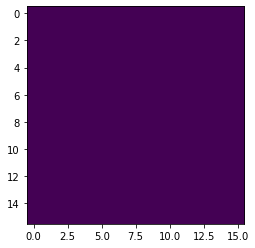

In [30]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




import matplotlib.pyplot as plt



env = Hierarchical_Maze(16
                        , 2, 4, 2, False,False,2,False,0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
env.goal_init_state=[4,4]

In [32]:



# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
num_episodes = 10000
batch_size = 1
discount_factor =1
learn_rate = 1e-4
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)
r_dict_3={}
env1=copy.copy(env)

device = torch.device("cpu")

for man_init in ['Learn']:
    for length in [7]:
    #     for num_hidden in  [int(n_input*1.1)]:
    # counter=0
        n_input = 2*length ** 2 + 8

        for num_hidden in  [int(2*length ** 2)]:
#             clear_output(wait=True)
    #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
    #     for length in [3]:
            memory = ReplayMemory(1)



            Q_policy = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)
            Q_target = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)

            # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
            # Q_target = QNetwork(n_input, num_hidden, device).to(device)

            # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
            # target_net = DQN(screen_height, screen_width, n_actions).to(device)
            Q_target.load_state_dict(Q_policy.state_dict())
            Q_target.eval()
            allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

            policy = EpsilonGreedyPolicy(Q_policy, 0.08)

            episode_durations, losses, Visit_table,rewards,ss = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                                  batch_size,
                                                                  discount_factor, learn_rate, np.minimum(500,num_episodes))
            r_dict_3[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                             'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
            counter=counter+1
    #         import matplotlib.pyplot as plt
    #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






  0%|                                                                             | 1/10000 [00:19<55:20:54, 19.93s/it]

epsilon 0.75


  1%|▍                                                                           | 51/10000 [04:06<19:33:17,  7.08s/it]

epsilon 0.7456875


  1%|▊                                                                           | 101/10000 [08:05<7:29:11,  2.72s/it]

epsilon 0.741375


  2%|█▏                                                                          | 151/10000 [11:34<7:59:52,  2.92s/it]

epsilon 0.7370625


  2%|█▌                                                                          | 201/10000 [13:26<6:14:23,  2.29s/it]

epsilon 0.73275


  3%|█▉                                                                          | 251/10000 [15:19<5:52:13,  2.17s/it]

epsilon 0.7284375


  3%|██▎                                                                         | 301/10000 [17:57<6:50:08,  2.54s/it]

epsilon 0.724125


  4%|██▋                                                                        | 351/10000 [20:09<10:16:38,  3.83s/it]

epsilon 0.7198125
[221.86]
min mean 221.86
last mean 350    221.86
dtype: float64


  4%|███                                                                        | 401/10000 [22:14<10:21:11,  3.88s/it]

epsilon 0.7155
[221.86, 187.40333333333334]
min mean 187.40333333333334
last mean 400    189.14
dtype: float64


  5%|███▍                                                                       | 451/10000 [24:22<10:06:02,  3.81s/it]

epsilon 0.7111875
[221.86, 187.40333333333334, 165.63666666666666]
min mean 165.63666666666666
last mean 450    169.61
dtype: float64


  5%|███▊                                                                        | 501/10000 [26:20<4:58:41,  1.89s/it]

epsilon 0.706875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666]
min mean 165.63666666666666
last mean 500    170.24
dtype: float64


  6%|████▏                                                                       | 552/10000 [28:33<3:23:09,  1.29s/it]

epsilon 0.7025625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666]
min mean 165.63666666666666
last mean 550    171.963333
dtype: float64


  6%|████▌                                                                       | 601/10000 [30:40<5:32:10,  2.12s/it]

epsilon 0.69825
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83]
min mean 163.83
last mean 600    164.513333
dtype: float64


  7%|████▉                                                                       | 651/10000 [32:14<3:31:32,  1.36s/it]

epsilon 0.6939375
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0]
min mean 157.0
last mean 650    157.0
dtype: float64


  7%|█████▎                                                                      | 701/10000 [34:07<5:26:42,  2.11s/it]

epsilon 0.689625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18]
min mean 153.18
last mean 700    155.543333
dtype: float64


  8%|█████▋                                                                      | 751/10000 [35:26<5:39:25,  2.20s/it]

epsilon 0.6853125
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666]
min mean 143.69666666666666
last mean 750    143.89
dtype: float64


  8%|██████                                                                      | 801/10000 [36:34<2:48:39,  1.10s/it]

epsilon 0.681
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334]
min mean 133.15333333333334
last mean 800    133.216667
dtype: float64


  9%|██████▍                                                                     | 851/10000 [37:43<2:38:35,  1.04s/it]

epsilon 0.6766875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667]
min mean 120.87666666666667
last mean 850    121.133333
dtype: float64


  9%|██████▊                                                                     | 901/10000 [39:03<2:48:49,  1.11s/it]

epsilon 0.672375
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666]
min mean 111.56666666666666
last mean 900    111.566667
dtype: float64


 10%|███████▏                                                                    | 951/10000 [40:22<4:03:21,  1.61s/it]

epsilon 0.6680625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667]
min mean 106.49666666666667
last mean 950    108.256667
dtype: float64


 10%|███████▌                                                                   | 1001/10000 [41:24<2:20:51,  1.06it/s]

epsilon 0.66375
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667]
min mean 97.40666666666667
last mean 1000    97.406667
dtype: float64


 11%|███████▉                                                                   | 1051/10000 [42:15<3:03:44,  1.23s/it]

epsilon 0.6594375
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62]
min mean 92.62
last mean 1050    92.62
dtype: float64


 11%|████████▎                                                                  | 1101/10000 [43:19<2:14:00,  1.11it/s]

epsilon 0.655125
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16]
min mean 92.16
last mean 1100    92.16
dtype: float64


 12%|████████▋                                                                  | 1151/10000 [44:20<1:57:21,  1.26it/s]

epsilon 0.6508125
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666]
min mean 89.73666666666666
last mean 1150    90.976667
dtype: float64


 12%|█████████                                                                  | 1201/10000 [45:17<2:47:40,  1.14s/it]

epsilon 0.6465
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667]
min mean 84.82666666666667
last mean 1200    86.443333
dtype: float64


 13%|█████████▍                                                                 | 1251/10000 [46:27<1:52:35,  1.30it/s]

epsilon 0.6421875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34]
min mean 83.34
last mean 1250    83.34
dtype: float64


 13%|█████████▊                                                                 | 1301/10000 [47:28<5:40:17,  2.35s/it]

epsilon 0.637875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667]
min mean 80.29666666666667
last mean 1300    81.78
dtype: float64


 14%|██████████▏                                                                | 1351/10000 [48:18<2:29:17,  1.04s/it]

epsilon 0.6335625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667]
min mean 80.29666666666667
last mean 1350    80.686667
dtype: float64


 14%|██████████▌                                                                | 1401/10000 [49:23<1:16:28,  1.87it/s]

epsilon 0.62925
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334]
min mean 77.96333333333334
last mean 1400    80.143333
dtype: float64


 15%|██████████▉                                                                | 1451/10000 [50:18<2:49:53,  1.19s/it]

epsilon 0.6249375
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53]
min mean 77.53
last mean 1450    78.196667
dtype: float64


 15%|███████████▎                                                               | 1501/10000 [50:59<2:11:53,  1.07it/s]

epsilon 0.620625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84]
min mean 73.84
last mean 1500    74.23
dtype: float64


 16%|███████████▋                                                               | 1551/10000 [51:57<3:27:30,  1.47s/it]

epsilon 0.6163125
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333]
min mean 70.70333333333333
last mean 1550    71.556667
dtype: float64


 16%|████████████                                                               | 1601/10000 [52:31<2:21:37,  1.01s/it]

epsilon 0.612
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667]
min mean 66.71666666666667
last mean 1600    66.716667
dtype: float64


 17%|████████████▍                                                              | 1651/10000 [53:18<2:07:23,  1.09it/s]

epsilon 0.6076875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13]
min mean 64.13
last mean 1650    66.42
dtype: float64


 17%|████████████▊                                                              | 1701/10000 [54:08<3:10:50,  1.38s/it]

epsilon 0.603375
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79]
min mean 61.79
last mean 1700    63.23
dtype: float64


 18%|█████████████▏                                                             | 1751/10000 [54:52<2:16:33,  1.01it/s]

epsilon 0.5990625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24]
min mean 60.24
last mean 1750    60.253333
dtype: float64


 18%|█████████████▌                                                             | 1801/10000 [55:35<3:00:37,  1.32s/it]

epsilon 0.59475
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335]
min mean 60.053333333333335
last mean 1800    60.84
dtype: float64


 19%|█████████████▉                                                             | 1851/10000 [56:13<1:39:34,  1.36it/s]

epsilon 0.5904375
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333]
min mean 56.39333333333333
last mean 1850    56.393333
dtype: float64


 19%|██████████████▎                                                            | 1901/10000 [56:48<1:48:00,  1.25it/s]

epsilon 0.586125
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334]
min mean 55.86333333333334
last mean 1900    56.246667
dtype: float64


 20%|██████████████▋                                                            | 1951/10000 [57:37<4:36:34,  2.06s/it]

epsilon 0.5818125000000001
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52]
min mean 54.52
last mean 1950    56.213333
dtype: float64


 20%|███████████████                                                            | 2001/10000 [58:33<1:42:50,  1.30it/s]

epsilon 0.5775
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52]
min mean 54.52
last mean 2000    57.226667
dtype: float64


 21%|███████████████▍                                                           | 2051/10000 [59:14<1:37:17,  1.36it/s]

epsilon 0.5731875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52]
min mean 54.52
last mean 2050    56.593333
dtype: float64


 21%|███████████████▊                                                           | 2101/10000 [59:56<2:13:20,  1.01s/it]

epsilon 0.568875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52]
min mean 54.52
last mean 2100    56.743333
dtype: float64


 22%|████████████████▏                                                          | 2151/10000 [1:00:25<58:24,  2.24it/s]

epsilon 0.5645625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52]
min mean 54.52
last mean 2150    56.026667
dtype: float64


 22%|████████████████▌                                                          | 2201/10000 [1:00:58<55:57,  2.32it/s]

epsilon 0.56025
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52]
min mean 54.52
last mean 2200    56.896667
dtype: float64


 23%|████████████████▉                                                          | 2252/10000 [1:01:26<43:53,  2.94it/s]

epsilon 0.5559375
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667]
min mean 53.67666666666667
last mean 2250    53.676667
dtype: float64


 23%|████████████████▊                                                        | 2301/10000 [1:01:53<1:10:00,  1.83it/s]

epsilon 0.551625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68]
min mean 48.68
last mean 2300    48.833333
dtype: float64


 24%|█████████████████▏                                                       | 2351/10000 [1:02:23<1:29:10,  1.43it/s]

epsilon 0.5473125
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54]
min mean 47.54
last mean 2350    48.023333
dtype: float64


 24%|█████████████████▌                                                       | 2401/10000 [1:02:52<1:19:24,  1.59it/s]

epsilon 0.5429999999999999
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77]
min mean 45.77
last mean 2400    45.83
dtype: float64


 25%|█████████████████▉                                                       | 2451/10000 [1:03:17<1:02:54,  2.00it/s]

epsilon 0.5386875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333]
min mean 44.63333333333333
last mean 2450    44.936667
dtype: float64


 25%|██████████████████▊                                                        | 2501/10000 [1:03:44<49:59,  2.50it/s]

epsilon 0.534375
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335]
min mean 43.553333333333335
last mean 2500    43.69
dtype: float64


 26%|███████████████████▏                                                       | 2551/10000 [1:04:09<51:47,  2.40it/s]

epsilon 0.5300625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77]
min mean 42.77
last mean 2550    42.9
dtype: float64


 26%|██████████████████▉                                                      | 2601/10000 [1:04:33<1:12:29,  1.70it/s]

epsilon 0.52575
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333]
min mean 41.93333333333333
last mean 2600    42.296667
dtype: float64


 27%|███████████████████▉                                                       | 2651/10000 [1:04:56<47:21,  2.59it/s]

epsilon 0.5214375
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665]
min mean 40.376666666666665
last mean 2650    40.376667
dtype: float64


 27%|████████████████████▎                                                      | 2701/10000 [1:05:16<44:55,  2.71it/s]

epsilon 0.5171250000000001
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333]
min mean 38.02333333333333
last mean 2700    38.023333
dtype: float64


 28%|████████████████████▋                                                      | 2751/10000 [1:05:37<50:38,  2.39it/s]

epsilon 0.5128125
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667]
min mean 37.06666666666667
last mean 2750    37.223333
dtype: float64


 28%|█████████████████████                                                      | 2801/10000 [1:05:59<51:58,  2.31it/s]

epsilon 0.5085000000000001
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16]
min mean 35.16
last mean 2800    35.526667
dtype: float64


 29%|█████████████████████▍                                                     | 2851/10000 [1:06:20<53:41,  2.22it/s]

epsilon 0.5041875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77]
min mean 34.77
last mean 2850    34.926667
dtype: float64


 29%|█████████████████████▊                                                     | 2901/10000 [1:06:42<38:30,  3.07it/s]

epsilon 0.499875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666]
min mean 34.336666666666666
last mean 2900    34.426667
dtype: float64


 30%|██████████████████████▏                                                    | 2951/10000 [1:07:02<52:47,  2.23it/s]

epsilon 0.4955625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666]
min mean 33.70666666666666
last mean 2950    33.853333
dtype: float64


 30%|██████████████████████▌                                                    | 3001/10000 [1:07:21<44:15,  2.64it/s]

epsilon 0.49125
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334]
min mean 33.61333333333334
last mean 3000    33.77
dtype: float64


 31%|██████████████████████▉                                                    | 3051/10000 [1:07:43<44:52,  2.58it/s]

epsilon 0.4869375
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666]
min mean 33.13666666666666
last mean 3050    33.853333
dtype: float64


 31%|███████████████████████▎                                                   | 3101/10000 [1:08:05<29:24,  3.91it/s]

epsilon 0.4826250000000001
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666]
min mean 33.13666666666666
last mean 3100    34.0
dtype: float64


 32%|███████████████████████▋                                                   | 3151/10000 [1:08:26<44:11,  2.58it/s]

epsilon 0.47831250000000003
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666]
min mean 33.13666666666666
last mean 3150    34.003333
dtype: float64


 32%|████████████████████████                                                   | 3201/10000 [1:08:46<42:17,  2.68it/s]

epsilon 0.47400000000000003
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666]
min mean 33.13666666666666
last mean 3200    33.816667
dtype: float64


 32%|████████████████████████▍                                                  | 3250/10000 [1:09:04<33:58,  3.31it/s]

epsilon 0.46968750000000004
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665]
min mean 32.986666666666665
last mean 3250    33.146667
dtype: float64


 33%|████████████████████████▊                                                  | 3301/10000 [1:09:21<54:30,  2.05it/s]

epsilon 0.46537500000000004
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41]
min mean 32.41
last mean 3300    32.69
dtype: float64


 34%|█████████████████████████▏                                                 | 3351/10000 [1:09:38<40:51,  2.71it/s]

epsilon 0.46106250000000004
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667]
min mean 31.206666666666667
last mean 3350    31.4
dtype: float64


 34%|█████████████████████████▌                                                 | 3401/10000 [1:09:55<36:06,  3.05it/s]

epsilon 0.45675000000000004
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53]
min mean 29.53
last mean 3400    30.103333
dtype: float64


 35%|█████████████████████████▉                                                 | 3451/10000 [1:10:15<47:54,  2.28it/s]

epsilon 0.45243750000000005
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668]
min mean 29.486666666666668
last mean 3450    30.093333
dtype: floa

 35%|██████████████████████████▎                                                | 3501/10000 [1:10:33<41:06,  2.64it/s]

epsilon 0.448125
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668]
min mean 29.346666666666668
last mean 3500    29.613333
dt

 36%|██████████████████████████▋                                                | 3551/10000 [1:10:52<33:23,  3.22it/s]

epsilon 0.44381250000000005
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668]
min mean 29.346666666666668

 36%|███████████████████████████                                                | 3601/10000 [1:11:10<46:53,  2.27it/s]

epsilon 0.4395
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668]
min mean 29.34666666

 37%|███████████████████████████▍                                               | 3651/10000 [1:11:28<39:15,  2.69it/s]

epsilon 0.4351875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 37%|███████████████████████████▊                                               | 3702/10000 [1:11:45<28:24,  3.69it/s]

epsilon 0.430875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668

 38%|████████████████████████████▏                                              | 3751/10000 [1:12:01<49:46,  2.09it/s]

epsilon 0.42656249999999996
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 38%|████████████████████████████▌                                              | 3801/10000 [1:12:19<28:34,  3.62it/s]

epsilon 0.42225
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668,

 39%|████████████████████████████▉                                              | 3852/10000 [1:12:35<29:45,  3.44it/s]

epsilon 0.4179375
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 39%|█████████████████████████████▎                                             | 3901/10000 [1:12:50<32:10,  3.16it/s]

epsilon 0.413625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668

 40%|█████████████████████████████▋                                             | 3951/10000 [1:13:06<43:05,  2.34it/s]

epsilon 0.4093125
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 40%|██████████████████████████████                                             | 4001/10000 [1:13:18<33:48,  2.96it/s]

epsilon 0.40499999999999997
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 41%|██████████████████████████████▍                                            | 4051/10000 [1:13:33<26:18,  3.77it/s]

epsilon 0.4006875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 41%|██████████████████████████████▊                                            | 4103/10000 [1:13:46<32:00,  3.07it/s]

epsilon 0.39637500000000003
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 42%|███████████████████████████████▏                                           | 4152/10000 [1:13:58<23:41,  4.11it/s]

epsilon 0.3920625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 42%|███████████████████████████████▌                                           | 4201/10000 [1:14:12<29:32,  3.27it/s]

epsilon 0.38775000000000004
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 43%|███████████████████████████████▉                                           | 4251/10000 [1:14:25<17:21,  5.52it/s]

epsilon 0.3834375
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 43%|████████████████████████████████▎                                          | 4301/10000 [1:14:37<24:01,  3.95it/s]

epsilon 0.379125
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668

 44%|████████████████████████████████▋                                          | 4351/10000 [1:14:52<29:49,  3.16it/s]

epsilon 0.3748125
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 44%|█████████████████████████████████                                          | 4401/10000 [1:15:06<25:12,  3.70it/s]

epsilon 0.3705
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 

 45%|█████████████████████████████████▍                                         | 4451/10000 [1:15:19<22:48,  4.05it/s]

epsilon 0.3661875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 45%|█████████████████████████████████▊                                         | 4501/10000 [1:15:33<22:19,  4.10it/s]

epsilon 0.36187500000000006
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 46%|██████████████████████████████████▏                                        | 4551/10000 [1:15:46<25:35,  3.55it/s]

epsilon 0.3575625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 46%|██████████████████████████████████▌                                        | 4601/10000 [1:15:58<24:21,  3.69it/s]

epsilon 0.35324999999999995
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 47%|██████████████████████████████████▉                                        | 4652/10000 [1:16:12<18:11,  4.90it/s]

epsilon 0.3489375
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 47%|███████████████████████████████████▎                                       | 4701/10000 [1:16:25<17:44,  4.98it/s]

epsilon 0.344625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668

 48%|███████████████████████████████████▋                                       | 4751/10000 [1:16:37<22:56,  3.81it/s]

epsilon 0.3403125
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 48%|████████████████████████████████████                                       | 4801/10000 [1:16:50<15:52,  5.46it/s]

epsilon 0.33599999999999997
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 49%|████████████████████████████████████▍                                      | 4851/10000 [1:17:03<26:05,  3.29it/s]

epsilon 0.3316875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 49%|████████████████████████████████████▊                                      | 4901/10000 [1:17:15<26:24,  3.22it/s]

epsilon 0.32737499999999997
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 50%|█████████████████████████████████████▏                                     | 4951/10000 [1:17:27<20:14,  4.16it/s]

epsilon 0.3230625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 50%|█████████████████████████████████████▌                                     | 5002/10000 [1:17:42<16:16,  5.12it/s]

epsilon 0.31875000000000003
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 51%|█████████████████████████████████████▉                                     | 5051/10000 [1:17:57<22:17,  3.70it/s]

epsilon 0.31443750000000004
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 51%|██████████████████████████████████████▎                                    | 5102/10000 [1:18:11<20:48,  3.92it/s]

epsilon 0.310125
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668

 52%|██████████████████████████████████████▋                                    | 5151/10000 [1:18:26<23:02,  3.51it/s]

epsilon 0.30581250000000004
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 52%|███████████████████████████████████████                                    | 5201/10000 [1:18:40<22:01,  3.63it/s]

epsilon 0.3015000000000001
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666

 53%|███████████████████████████████████████▍                                   | 5251/10000 [1:18:52<19:01,  4.16it/s]

epsilon 0.29718750000000005
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 53%|███████████████████████████████████████▊                                   | 5301/10000 [1:19:05<21:16,  3.68it/s]

epsilon 0.29287500000000005
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 54%|████████████████████████████████████████▏                                  | 5351/10000 [1:19:19<22:12,  3.49it/s]

epsilon 0.28856250000000006
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 54%|████████████████████████████████████████▌                                  | 5401/10000 [1:19:33<19:48,  3.87it/s]

epsilon 0.2842500000000001
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666

 55%|████████████████████████████████████████▉                                  | 5451/10000 [1:19:47<17:33,  4.32it/s]

epsilon 0.27993750000000006
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 55%|█████████████████████████████████████████▎                                 | 5501/10000 [1:20:00<19:24,  3.86it/s]

epsilon 0.275625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668

 56%|█████████████████████████████████████████▋                                 | 5551/10000 [1:20:17<27:41,  2.68it/s]

epsilon 0.27131250000000007
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 56%|██████████████████████████████████████████                                 | 5601/10000 [1:20:30<19:01,  3.85it/s]

epsilon 0.26700000000000007
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 57%|██████████████████████████████████████████▍                                | 5652/10000 [1:20:43<16:26,  4.41it/s]

epsilon 0.2626875000000001
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666

 57%|██████████████████████████████████████████▊                                | 5701/10000 [1:20:57<23:24,  3.06it/s]

epsilon 0.25837500000000013
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 58%|███████████████████████████████████████████▏                               | 5751/10000 [1:21:10<21:29,  3.29it/s]

epsilon 0.2540625000000001
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666

 58%|███████████████████████████████████████████▌                               | 5801/10000 [1:21:24<21:20,  3.28it/s]

epsilon 0.24975000000000003
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 59%|███████████████████████████████████████████▉                               | 5851/10000 [1:21:38<20:01,  3.45it/s]

epsilon 0.24543749999999998
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 59%|████████████████████████████████████████████▎                              | 5901/10000 [1:21:51<23:54,  2.86it/s]

epsilon 0.24112500000000003
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 60%|████████████████████████████████████████████▋                              | 5951/10000 [1:22:05<18:46,  3.59it/s]

epsilon 0.2368125000000001
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666

 60%|█████████████████████████████████████████████                              | 6001/10000 [1:22:20<20:27,  3.26it/s]

epsilon 0.23250000000000004
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 61%|█████████████████████████████████████████████▍                             | 6051/10000 [1:22:34<18:11,  3.62it/s]

epsilon 0.2281875000000001
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666

 61%|█████████████████████████████████████████████▊                             | 6101/10000 [1:22:48<15:46,  4.12it/s]

epsilon 0.22387500000000005
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 62%|██████████████████████████████████████████████▏                            | 6151/10000 [1:23:02<19:20,  3.32it/s]

epsilon 0.2195625000000001
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666

 62%|██████████████████████████████████████████████▌                            | 6201/10000 [1:23:17<18:55,  3.34it/s]

epsilon 0.21525000000000016
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 63%|██████████████████████████████████████████████▉                            | 6251/10000 [1:23:32<18:34,  3.36it/s]

epsilon 0.2109375000000001
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666

 63%|███████████████████████████████████████████████▎                           | 6301/10000 [1:23:47<16:04,  3.84it/s]

epsilon 0.20662500000000006
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 64%|███████████████████████████████████████████████▋                           | 6351/10000 [1:24:01<14:05,  4.32it/s]

epsilon 0.2023125
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 64%|████████████████████████████████████████████████                           | 6401/10000 [1:24:15<14:10,  4.23it/s]

epsilon 0.19800000000000006
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 65%|████████████████████████████████████████████████▍                          | 6451/10000 [1:24:30<20:44,  2.85it/s]

epsilon 0.1936875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 65%|████████████████████████████████████████████████▊                          | 6501/10000 [1:24:43<14:24,  4.05it/s]

epsilon 0.18937500000000007
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 66%|█████████████████████████████████████████████████▏                         | 6551/10000 [1:24:57<14:59,  3.83it/s]

epsilon 0.18506250000000013
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 66%|█████████████████████████████████████████████████▌                         | 6602/10000 [1:25:12<12:35,  4.50it/s]

epsilon 0.18075000000000008
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 67%|█████████████████████████████████████████████████▉                         | 6651/10000 [1:25:26<18:07,  3.08it/s]

epsilon 0.17643750000000002
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 67%|██████████████████████████████████████████████████▎                        | 6701/10000 [1:25:41<12:51,  4.28it/s]

epsilon 0.17212500000000008
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 68%|██████████████████████████████████████████████████▋                        | 6751/10000 [1:25:55<17:32,  3.09it/s]

epsilon 0.16781250000000014
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 68%|███████████████████████████████████████████████████                        | 6801/10000 [1:26:08<13:42,  3.89it/s]

epsilon 0.1635000000000001
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666

 69%|███████████████████████████████████████████████████▍                       | 6851/10000 [1:26:23<17:24,  3.02it/s]

epsilon 0.15918750000000004
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 69%|███████████████████████████████████████████████████▊                       | 6901/10000 [1:26:36<13:24,  3.85it/s]

epsilon 0.1548750000000001
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666

 70%|████████████████████████████████████████████████████▏                      | 6951/10000 [1:26:50<24:28,  2.08it/s]

epsilon 0.15056250000000004
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 70%|████████████████████████████████████████████████████▌                      | 7001/10000 [1:27:04<15:32,  3.22it/s]

epsilon 0.14625
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668,

 71%|████████████████████████████████████████████████████▉                      | 7051/10000 [1:27:18<15:33,  3.16it/s]

epsilon 0.14193750000000005
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 71%|█████████████████████████████████████████████████████▎                     | 7101/10000 [1:27:32<14:28,  3.34it/s]

epsilon 0.1376250000000001
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666

 72%|█████████████████████████████████████████████████████▋                     | 7151/10000 [1:27:46<13:17,  3.57it/s]

epsilon 0.13331249999999994
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 72%|██████████████████████████████████████████████████████                     | 7201/10000 [1:28:01<14:27,  3.22it/s]

epsilon 0.129
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 2

 73%|██████████████████████████████████████████████████████▍                    | 7251/10000 [1:28:15<11:56,  3.84it/s]

epsilon 0.12468750000000006
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 73%|██████████████████████████████████████████████████████▊                    | 7301/10000 [1:28:30<10:37,  4.23it/s]

epsilon 0.12037500000000001
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 74%|███████████████████████████████████████████████████████▏                   | 7351/10000 [1:28:44<12:04,  3.65it/s]

epsilon 0.11606250000000007
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 74%|███████████████████████████████████████████████████████▌                   | 7401/10000 [1:28:58<13:51,  3.13it/s]

epsilon 0.11175000000000002
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 75%|███████████████████████████████████████████████████████▉                   | 7451/10000 [1:29:11<11:22,  3.73it/s]

epsilon 0.10743749999999996
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 75%|████████████████████████████████████████████████████████▎                  | 7501/10000 [1:29:25<10:36,  3.93it/s]

epsilon 0.10312499999999991
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 76%|████████████████████████████████████████████████████████▋                  | 7551/10000 [1:29:39<13:34,  3.01it/s]

epsilon 0.09881249999999997
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 76%|█████████████████████████████████████████████████████████                  | 7601/10000 [1:29:53<11:09,  3.58it/s]

epsilon 0.09450000000000003
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 77%|█████████████████████████████████████████████████████████▍                 | 7651/10000 [1:30:06<10:35,  3.70it/s]

epsilon 0.09018749999999998
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 77%|█████████████████████████████████████████████████████████▊                 | 7701/10000 [1:30:20<10:45,  3.56it/s]

epsilon 0.08587500000000003
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 78%|██████████████████████████████████████████████████████████▏                | 7751/10000 [1:30:34<09:44,  3.85it/s]

epsilon 0.08156249999999998
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 78%|██████████████████████████████████████████████████████████▌                | 7801/10000 [1:30:46<09:55,  3.69it/s]

epsilon 0.07725000000000004
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 79%|██████████████████████████████████████████████████████████▉                | 7851/10000 [1:31:03<10:39,  3.36it/s]

epsilon 0.07293749999999999
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 79%|███████████████████████████████████████████████████████████▎               | 7901/10000 [1:31:20<32:06,  1.09it/s]

epsilon 0.06862500000000005
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 80%|███████████████████████████████████████████████████████████▋               | 7951/10000 [1:31:38<11:35,  2.95it/s]

epsilon 0.0643125
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 80%|████████████████████████████████████████████████████████████               | 8001/10000 [1:31:51<09:01,  3.69it/s]

epsilon 0.05999999999999994
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 81%|████████████████████████████████████████████████████████████▍              | 8051/10000 [1:32:07<10:18,  3.15it/s]

epsilon 0.0556875
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.34666666666666

 81%|████████████████████████████████████████████████████████████▊              | 8101/10000 [1:32:25<08:26,  3.75it/s]

epsilon 0.05137499999999995
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.3466

 82%|█████████████████████████████████████████████████████████████▏             | 8151/10000 [1:32:48<08:05,  3.81it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 82%|█████████████████████████████████████████████████████████████▌             | 8201/10000 [1:33:02<07:57,  3.77it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 83%|█████████████████████████████████████████████████████████████▉             | 8251/10000 [1:33:16<07:05,  4.11it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 83%|██████████████████████████████████████████████████████████████▎            | 8301/10000 [1:33:29<08:37,  3.29it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 84%|██████████████████████████████████████████████████████████████▋            | 8351/10000 [1:33:43<07:50,  3.51it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 84%|███████████████████████████████████████████████████████████████            | 8401/10000 [1:33:58<08:57,  2.98it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 85%|███████████████████████████████████████████████████████████████▍           | 8451/10000 [1:34:12<08:01,  3.21it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 85%|███████████████████████████████████████████████████████████████▊           | 8501/10000 [1:34:26<06:24,  3.90it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 86%|████████████████████████████████████████████████████████████████▏          | 8551/10000 [1:34:39<06:32,  3.70it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 86%|████████████████████████████████████████████████████████████████▌          | 8601/10000 [1:34:56<07:08,  3.26it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 87%|████████████████████████████████████████████████████████████████▉          | 8651/10000 [1:35:12<07:23,  3.04it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 87%|█████████████████████████████████████████████████████████████████▎         | 8701/10000 [1:35:27<11:45,  1.84it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 88%|█████████████████████████████████████████████████████████████████▋         | 8751/10000 [1:35:43<08:06,  2.57it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 88%|██████████████████████████████████████████████████████████████████         | 8801/10000 [1:35:59<06:37,  3.01it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 89%|██████████████████████████████████████████████████████████████████▍        | 8851/10000 [1:36:14<05:20,  3.59it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 89%|██████████████████████████████████████████████████████████████████▊        | 8901/10000 [1:36:28<05:43,  3.20it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 90%|███████████████████████████████████████████████████████████████████▏       | 8951/10000 [1:36:47<06:45,  2.58it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 90%|███████████████████████████████████████████████████████████████████▌       | 9001/10000 [1:37:01<04:28,  3.71it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 91%|███████████████████████████████████████████████████████████████████▉       | 9051/10000 [1:37:20<11:04,  1.43it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 91%|████████████████████████████████████████████████████████████████████▎      | 9101/10000 [1:37:35<04:02,  3.71it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 92%|████████████████████████████████████████████████████████████████████▋      | 9151/10000 [1:37:50<04:37,  3.06it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 92%|█████████████████████████████████████████████████████████████████████      | 9201/10000 [1:38:04<03:30,  3.80it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 93%|█████████████████████████████████████████████████████████████████████▍     | 9251/10000 [1:38:20<04:13,  2.95it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 93%|█████████████████████████████████████████████████████████████████████▊     | 9301/10000 [1:38:35<03:23,  3.44it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 94%|██████████████████████████████████████████████████████████████████████▏    | 9351/10000 [1:38:49<03:48,  2.84it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 94%|██████████████████████████████████████████████████████████████████████▌    | 9401/10000 [1:39:03<03:00,  3.32it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 95%|██████████████████████████████████████████████████████████████████████▉    | 9451/10000 [1:39:18<02:53,  3.17it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 95%|███████████████████████████████████████████████████████████████████████▎   | 9501/10000 [1:39:33<02:44,  3.04it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 96%|███████████████████████████████████████████████████████████████████████▋   | 9551/10000 [1:39:47<02:01,  3.69it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 96%|████████████████████████████████████████████████████████████████████████   | 9601/10000 [1:40:03<01:53,  3.51it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 97%|████████████████████████████████████████████████████████████████████████▍  | 9651/10000 [1:40:17<01:24,  4.11it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 97%|████████████████████████████████████████████████████████████████████████▊  | 9701/10000 [1:40:32<01:33,  3.21it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 98%|█████████████████████████████████████████████████████████████████████████▏ | 9751/10000 [1:40:47<01:28,  2.81it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 98%|█████████████████████████████████████████████████████████████████████████▌ | 9801/10000 [1:41:03<00:57,  3.49it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 99%|█████████████████████████████████████████████████████████████████████████▉ | 9851/10000 [1:41:22<00:57,  2.57it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

 99%|██████████████████████████████████████████████████████████████████████████▎| 9901/10000 [1:41:39<00:42,  2.34it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

100%|██████████████████████████████████████████████████████████████████████████▋| 9951/10000 [1:41:55<00:16,  3.06it/s]

epsilon 0.05
[221.86, 187.40333333333334, 165.63666666666666, 165.63666666666666, 165.63666666666666, 163.83, 157.0, 153.18, 143.69666666666666, 133.15333333333334, 120.87666666666667, 111.56666666666666, 106.49666666666667, 97.40666666666667, 92.62, 92.16, 89.73666666666666, 84.82666666666667, 83.34, 80.29666666666667, 80.29666666666667, 77.96333333333334, 77.53, 73.84, 70.70333333333333, 66.71666666666667, 64.13, 61.79, 60.24, 60.053333333333335, 56.39333333333333, 55.86333333333334, 54.52, 54.52, 54.52, 54.52, 54.52, 54.52, 53.67666666666667, 48.68, 47.54, 45.77, 44.63333333333333, 43.553333333333335, 42.77, 41.93333333333333, 40.376666666666665, 38.02333333333333, 37.06666666666667, 35.16, 34.77, 34.336666666666666, 33.70666666666666, 33.61333333333334, 33.13666666666666, 33.13666666666666, 33.13666666666666, 33.13666666666666, 32.986666666666665, 32.41, 31.206666666666667, 29.53, 29.486666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29.346666666666668, 29

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [1:42:09<00:00,  1.63it/s]


In [3]:
print_policy(Q_policy, env, 0, 0)

NameError: name 'Q_policy' is not defined

<AxesSubplot:>

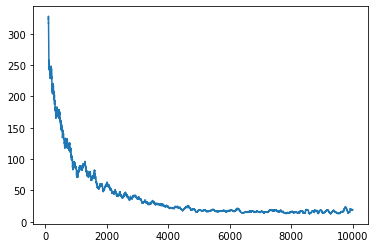

In [26]:
pd.Series(episode_durations).rolling(100).mean().plot()

<AxesSubplot:>

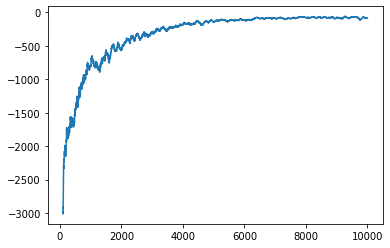

In [27]:
pd.Series(rewards).rolling(100).mean().plot()

In [28]:
pd.Series(losses).rolling(1000).mean()


0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
499206    3.809676
499207    3.807283
499208    3.807270
499209    3.807239
499210    3.807307
Length: 499211, dtype: float64

In [31]:
def print_policy(Q_policy, env, val_1, val_2):
    val_2=0
    val_1=0
    j = []
    jv = []
    j1v = []
    el = env.maze.shape[0]
    ml = env.manager_view
    em = int(el / ml)
    lisv = []
    sm = []
    man_ag = {}
    for y in range(el):
        for j2 in range(el):
            a = env.get_super_manager_1([y, j2])

    #          a is manager e.g. 3,3
    #  what's the equivalent for manager to pass when getting task

            man_ag[y * el + j2] = a[1][0] * (el/env.manager_view*(env.n_layers-1)) + a[1][1]
            if a[-1] not in sm:
                lisv.append(y * el + j2)
                sm.append(a[-1])

    for i, s in enumerate(lisv):
        #     if int(s/8)+s%8<16:

        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        m = 1

        aa = env.possible_actions(m, [int(s / el), s % el])
        loc_idx2, locs = Q_policy.get_subs(sm[i], env, 1)

        t = 4
        state[el ** 2:2 * el ** 2] = 0
        state[el ** 2 + loc_idx2] = 1
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + env.n_layers+1 + t] = 1
        #         print(state)

        j.append(action_dict[aa[torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[1].item()]])
        j1v.append(torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[0].item())
        jv.append([(x, Q_policy.forward(state, 1, env).flatten()[x].item()) for x in aa])
    print(np.array(j).reshape(em, em))
    print(np.array(jv).reshape(em, em))

    j2 = []
    j2v = []
    value_list = {}
    for s in range(el ** 2):

        #     if int(s/8)+s%8<16:
        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        #         aa=env.possible_actions(m,[int(s/8),s%8])
        state[el ** 2:2 * el ** 2] = val_2
        m = 2
    #     this is used to find task
        p = int(man_ag[s])
        # p = int(s / 4) * 2 + int((s / 2) % 4)
        t = action_dict_r[j[p]]
        gm = env.get_super_manager_1([int(s / el), int(s % el)])[1]
        for x in range(el ** 2):
            sm = env.get_super_manager_1([int(x / el), int(x % el)])[1]
            if sm == gm:
                state[el ** 2 + x] = 0

        state[s + el ** 2] = 1
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + 3 + t] = 1
        #         print(p, s, m, t)
        #         print()
        #         print(state)
        if [int(s / el), int(s % el)] == env.goal_init_state:
            j2.append('X')
            j2v.append(0)
        elif env.maze[int(s / el), int(s % el)] == 1:
            vv = Q_policy.forward(state, 2, env)
            j2.append('M' + action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
        else:
            vv = Q_policy.forward(state, 2, env)
            value_list[s] = vv.cpu().detach().numpy()
            j2.append(action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
    print(np.array(j2).reshape(el, el
                               ))
    print('xxx')

    V = np.array(j1v)
    num_man = int(el / ml)
    cells = [[x, y] for x in range(num_man) for y in range(num_man)]
    policy = np.array(j).reshape(num_man, num_man)

    fig, ax = plt.subplots()
    im = ax.imshow(np.reshape(V, (-1, num_man)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        #     if env.good_cell[cell[0],cell[1]]==1:
        #         text = ax.text(cell[1], cell[0], "Ma",
        #                        ha="center", va="center", color="w")

        if cell == env.get_super_manager_1(env.goal_init_state)[1]:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w")
        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    plt.title('Policy Managerial level')

    plt.show()
    # print('cccc')

    # levlel_2_policy={x:action_map[2][x][t] for x in action_map[2].keys()}
    V = np.array(j2v)
    cells = [[x, y] for x in range(el) for y in range(el)]
    policy = np.array(j2).reshape(el, el)

    fig, ax = plt.subplots()
    V = np.sign(V) * (np.abs(V) ** 0.5)
    im = ax.imshow(np.reshape(V, (-1, el)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        if cell == env.goal_init_state:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w", weight='bold')
        elif env.maze[cell[0], cell[1]] == 1:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]] + '_M',
                           ha="center", va="center", color="w")

        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    fig.set_size_inches(18.5, 10.5)
    plt.title('Policy lower level')
    plt.show()
    print('cccc')
    return j1v,j2v

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:450: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
9
tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 1., 0., 1., 0., 1.],
          [0., 0., 1., 1., 0., 0., 1., 1.],
          [0., 1., 1., 1., 0., 1., 1., 1.],
          [0., 0., 0., 0., 1., 1., 1., 1.],
          [0., 1., 0., 1., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1., 1., 1., 1.],
          [0., 1., 1., 1., 1., 1., 1., 1.]],

         [[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])
10
tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 1., 0., 1., 0., 1.],
  

ValueError: only one element tensors can be converted to Python scalars

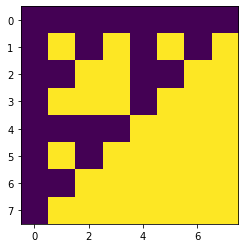

In [14]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




import matplotlib.pyplot as plt



env = Hierarchical_Maze(8
                        , 2, 2, 4, False,True,2,True,0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
env.goal_init_state=[4,4]


# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
# num_episodes = 10000
batch_size = 1
discount_factor =1
learn_rate = 1e-4
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)
r_dict_4={}
env2=copy.copy(env)
device = torch.device("cpu")

for man_init in ['Init','Nil','Exact','Learn']:
    for length in [7]:
    #     for num_hidden in  [int(n_input*1.1)]:
    # counter=0
        n_input = 2*length ** 2 + 8

        for num_hidden in  [int(2*length ** 2)]:
            clear_output(wait=True)
    #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
    #     for length in [3]:
            memory = ReplayMemory(1)



            Q_policy = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)
            Q_target = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)

            # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
            # Q_target = QNetwork(n_input, num_hidden, device).to(device)

            # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
            # target_net = DQN(screen_height, screen_width, n_actions).to(device)
            Q_target.load_state_dict(Q_policy.state_dict())
            Q_target.eval()
            allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

            policy = EpsilonGreedyPolicy(Q_policy, 0.08)

            episode_durations, losses, Visit_table,rewards,ss = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                                  batch_size,
                                                                  discount_factor, learn_rate, np.minimum(500,num_episodes))
            r_dict_4[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                             'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
            counter=counter+1
    #         import matplotlib.pyplot as plt
    #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






[5, 3]
[[1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


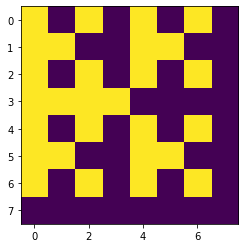

In [6]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




import matplotlib.pyplot as plt



env = Hierarchical_Maze(8
                        , 2, 2, 2, False,False,2,True,0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
env.goal_init_state=[4,4]

r_dict_5={}

# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
# num_episodes = 10000
batch_size = 1
discount_factor =1
learn_rate = 1e-5
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cpu")
env3=copy.copy(env)

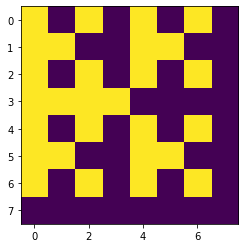

In [7]:
plt.imshow(env.maze)

In [22]:
r_d

dict_keys([0, 1, 2, 3])

In [11]:
# r_dict_5[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
#                              'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
# counter=counter+1

In [12]:


for man_init in ['Init','Nil','Exact']:
    for length in [7]:
    #     for num_hidden in  [int(n_input*1.1)]:
    # counter=0
        n_input = 2*length ** 2 + 8

        for num_hidden in  [int(2*length ** 2)]:
            clear_output(wait=True)
    #                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
    #     for length in [3]:
            memory = ReplayMemory(1)



            Q_policy = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)
            Q_target = QNetwork(env, n_input, num_hidden, device,length,man_init).to(device)

            # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
            # Q_target = QNetwork(n_input, num_hidden, device).to(device)

            # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
            # target_net = DQN(screen_height, screen_width, n_actions).to(device)
            Q_target.load_state_dict(Q_policy.state_dict())
            Q_target.eval()
            allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

            policy = EpsilonGreedyPolicy(Q_policy, 0.08)

            episode_durations, losses, Visit_table,rewards,ss = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                                  batch_size,
                                                                  discount_factor, learn_rate, np.minimum(500,num_episodes))
            r_dict_5[counter]={'man_init':man_init,'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                             'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
            counter=counter+1
    #         import matplotlib.pyplot as plt
    #         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [2:41:32<00:00,  2.06it/s]

Diverged


In [13]:
# r_dict_5.keys()

Exact
Parameter containing:
tensor([[ 1.,  4., 16.]]) Parameter containing:
tensor([0.])
[1.0, 4.0, 16.0]
Ratio M/L: 4.0
Learn
Parameter containing:
tensor([[0.3451, 0.6652, 1.0469]], requires_grad=True) Parameter containing:
tensor([0.3912], requires_grad=True)
[0.7362988591194153, 1.0564887523651123, 1.438147783279419]
Ratio M/L: 1.3612523371024106
Exact 87.39
Learn 78.59


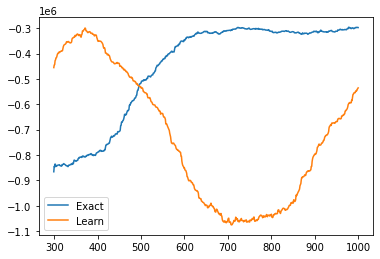

Exact 87.39
Learn 78.59


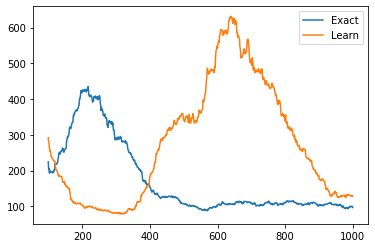

Exact -828.57
Learn -739.38


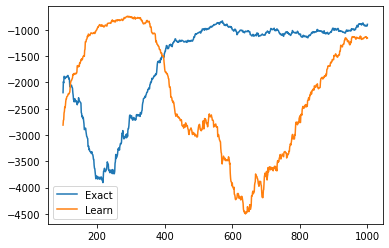

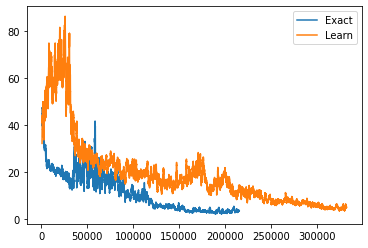

In [27]:
rr=2
for x in range(rr):
    labelp=r_dict_3[x]['man_init']
    nn=r_dict_3[x]['Q_policy']
    out=[]
    for i in range(3):
        x=torch.zeros(3)
        x[i]=1
    #     ([0.,0.,1.]
        out.append(nn.man_layer(x).item())
    
    
    print(labelp)
    print("=====================")
    print(nn.man_layer.weight,nn.man_layer.bias)
    print(out)
    print('Ratio M/L:',out[2]/out[1])
    print("=====================")
    print("=====================")
#     print_policy(nn, env1, 0, 0)
    print("=====================")

    
#     pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
# plt.legend()
for x in range(rr):
    labelp=r_dict_3[x]['man_init']
    
    print(labelp,pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_3[x]['rewards']).rolling(300).sum().tail(3000).plot(label=labelp)
plt.legend()
plt.show()
for x in range(rr):
    labelp=r_dict_3[x]['man_init']
    
    print(labelp,pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(rr):
    labelp=r_dict_3[x]['man_init']
    print(labelp,pd.Series(r_dict_3[x]['rewards']).rolling(100).mean().max())

    pd.Series(r_dict_3[x]['rewards']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(rr):
    labelp=r_dict_3[x]['man_init']
    pd.Series(r_dict_3[x]['losses']).rolling(1000).mean().plot(label=labelp)
plt.legend()
plt.show()

Init 5.65
Nil 5.94
Exact 6.03
Learn 5.55


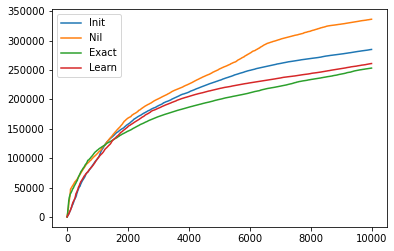

Init
Parameter containing:
tensor([[0.9594, 2.2061, 3.8590]], requires_grad=True) Parameter containing:
tensor([0.])
[0.959416389465332, 2.2061359882354736, 3.858994245529175]
Ratio M/L: 1.749209598187871
[['S' 'E' 'S' 'S']
 ['S' 'E' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['N' 'E' 'N' 'N']]
[[list([(0, -33.60409164428711), (1, -30.605737686157227), (2, -31.121763229370117), (3, -34.56023025512695)])
  list([(0, -33.135536193847656), (1, -30.163545608520508), (2, -29.18468475341797), (3, -31.943134307861328)])
  list([(0, -28.201358795166016), (1, -25.075258255004883), (2, -26.532081604003906), (3, -27.808866500854492)])
  list([(0, -27.762866973876953), (1, -25.737812042236328), (2, -25.972698211669922), (3, -26.559967041015625)])]
 [list([(0, -30.71514892578125), (1, -28.14796257019043), (2, -29.83463478088379), (3, -32.80111312866211)])
  list([(0, -26.857574462890625), (1, -24.691009521484375), (2, -24.412857055664062), (3, -26.566051483154297)])
  list([(0, -17.79079818725586), (1, -15.

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:544: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



xxx


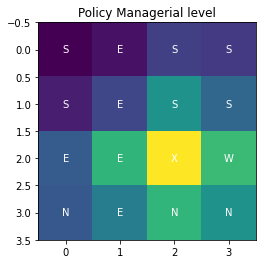

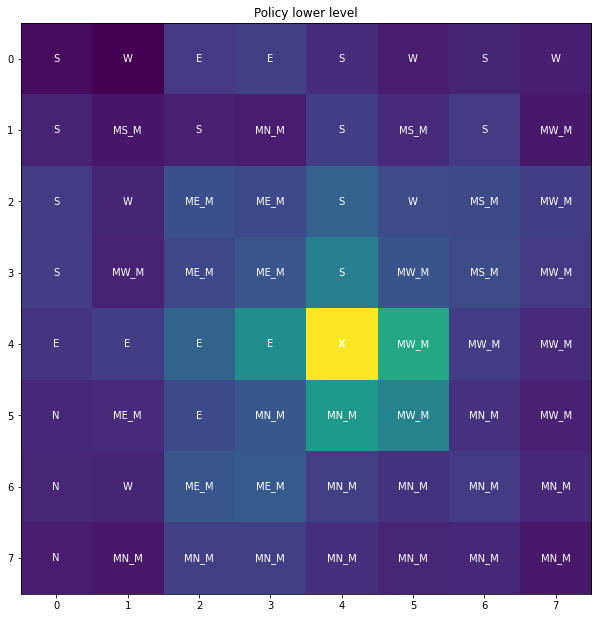

cccc
Nil
Parameter containing:
tensor([[1., 1., 1.]]) Parameter containing:
tensor([0.])
[1.0, 1.0, 1.0]
Ratio M/L: 1.0
[['E' 'E' 'S' 'S']
 ['S' 'S' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['E' 'N' 'N' 'W']]
[[list([(0, -39.13351821899414), (1, -37.98202133178711), (2, -36.87229537963867), (3, -40.22950744628906)])
  list([(0, -37.92253494262695), (1, -37.3991813659668), (2, -36.119693756103516), (3, -38.66656494140625)])
  list([(0, -32.85078430175781), (1, -30.34796905517578), (2, -32.736488342285156), (3, -33.71711349487305)])
  list([(0, -33.514366149902344), (1, -33.501617431640625), (2, -33.50210189819336), (3, -33.5423583984375)])]
 [list([(0, -37.46202850341797), (1, -35.185428619384766), (2, -35.29792785644531), (3, -38.8594970703125)])
  list([(0, -32.83070373535156), (1, -31.20728302001953), (2, -31.245370864868164), (3, -33.47217559814453)])
  list([(0, -23.30426025390625), (1, -17.823976516723633), (2, -23.9934139251709), (3, -24.26616096496582)])
  list([(0, -27.9129695892334),

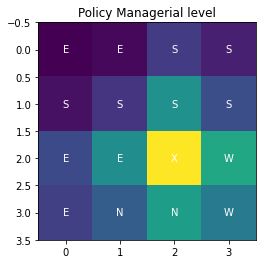

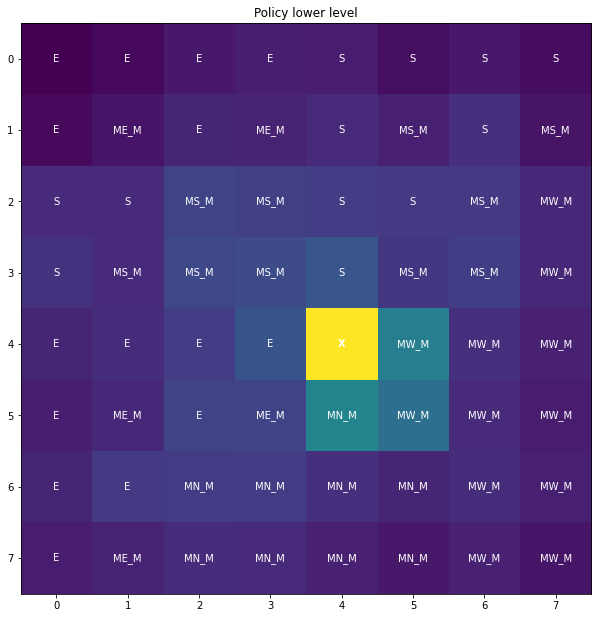

cccc
Exact
Parameter containing:
tensor([[1., 2., 4.]]) Parameter containing:
tensor([0.])
[1.0, 2.0, 4.0]
Ratio M/L: 2.0
[['S' 'E' 'S' 'S']
 ['S' 'S' 'S' 'S']
 ['E' 'E' 'Search' 'W']
 ['S' 'W' 'N' 'W']]
[[list([(0, -33.60454559326172), (1, -28.224720001220703), (2, -28.575462341308594), (3, -33.411476135253906)])
  list([(0, -32.887447357177734), (1, -28.765748977661133), (2, -26.537403106689453), (3, -31.24402618408203)])
  list([(0, -27.947704315185547), (1, -22.830724716186523), (2, -25.342220306396484), (3, -27.44436264038086)])
  list([(0, -29.3397274017334), (1, -26.39025115966797), (2, -26.98586654663086), (3, -27.409423828125)])]
 [list([(0, -32.322998046875), (1, -25.936641693115234), (2, -29.116390228271484), (3, -33.490814208984375)])
  list([(0, -27.73056983947754), (1, -23.523889541625977), (2, -23.886573791503906), (3, -27.512149810791016)])
  list([(0, -18.55546760559082), (1, -12.665411949157715), (2, -21.265846252441406), (3, -20.883529663085938)])
  list([(0, -24.217

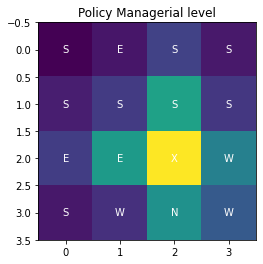

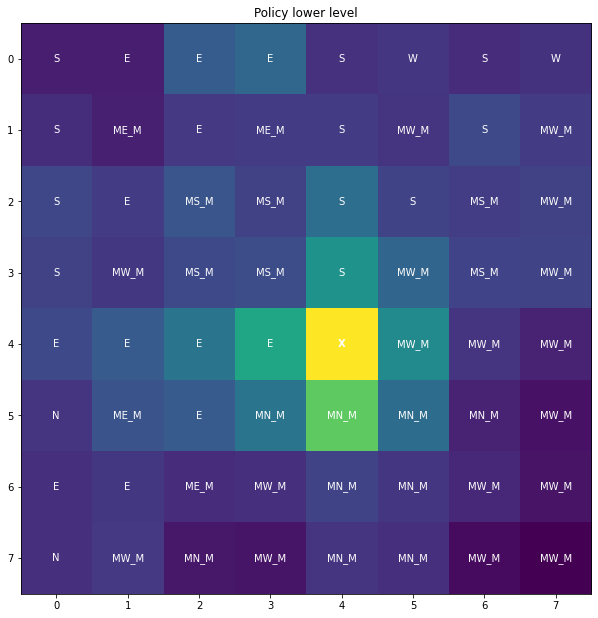

cccc
Learn
Parameter containing:
tensor([[ 0.2738, -0.1269, -0.5435]], requires_grad=True) Parameter containing:
tensor([-0.7304], requires_grad=True)
[-0.45658814907073975, -0.8572569489479065, -1.273883581161499]
Ratio M/L: 1.4859997142337658
[['S' 'E' 'S' 'S']
 ['S' 'W' 'N' 'N']
 ['E' 'E' 'Search' 'W']
 ['N' 'W' 'N' 'W']]
[[list([(0, -44.671451568603516), (1, -42.488739013671875), (2, -44.23430633544922), (3, -44.77064514160156)])
  list([(0, -43.039608001708984), (1, -42.167423248291016), (2, -42.081581115722656), (3, -42.47798538208008)])
  list([(0, -36.76315689086914), (1, -35.616554260253906), (2, -37.8534049987793), (3, -36.45732116699219)])
  list([(0, -33.95166778564453), (1, -33.42566680908203), (2, -35.17577362060547), (3, -33.4271240234375)])]
 [list([(0, -41.64622497558594), (1, -40.081851959228516), (2, -41.917686462402344), (3, -42.340362548828125)])
  list([(0, -36.117149353027344), (1, -36.59833908081055), (2, -35.99087905883789), (3, -35.95302963256836)])
  list([(0

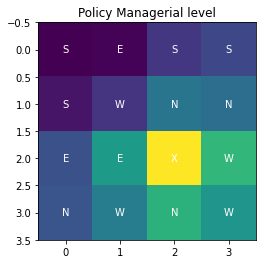

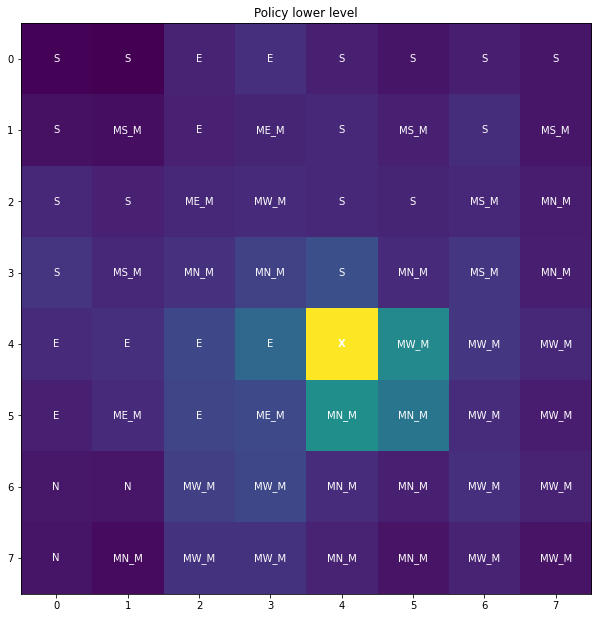

cccc
Init 5.68
Nil 5.25
Exact 5.04
Learn 5.87


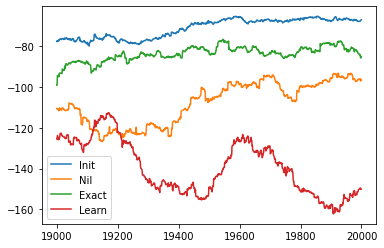

Init 5.68
Nil 5.25
Exact 5.04
Learn 5.87


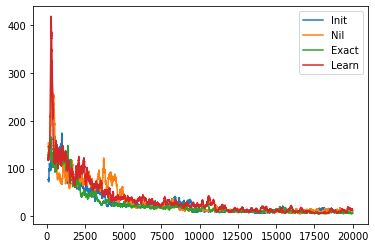

Init -59.13
Nil -66.18
Exact -64.56
Learn -75.24


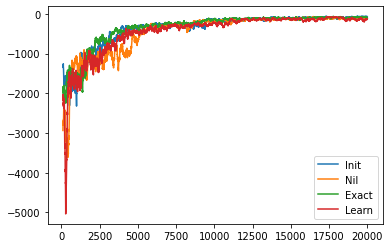

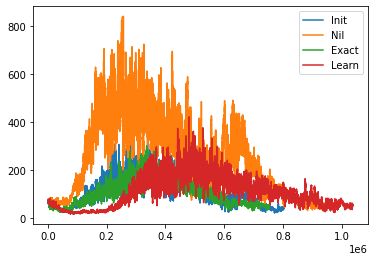

In [19]:
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    nn=r_dict_4[x]['Q_policy']
    out=[]
    for i in range(3):
        x=torch.zeros(3)
        x[i]=1
    #     ([0.,0.,1.]
        out.append(nn.man_layer(x).item())
    
    
    print(labelp)
    print("=====================")
    print(nn.man_layer.weight,nn.man_layer.bias)
    print(out)
    print('Ratio M/L:',out[2]/out[1])
    print("=====================")
    print("=====================")
    print_policy(nn, env2, 0, 0)
    print("=====================")

    
#     pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
# plt.legend()
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    
    print(labelp,pd.Series(r_dict_4[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_4[x]['rewards']).rolling(300).mean().tail(1000).plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    
    print(labelp,pd.Series(r_dict_4[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_4[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    print(labelp,pd.Series(r_dict_4[x]['rewards']).rolling(100).mean().max())

    pd.Series(r_dict_4[x]['rewards']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_4[x]['man_init']
    pd.Series(r_dict_4[x]['losses']).rolling(1000).mean().plot(label=labelp)
plt.legend()
plt.show()

Learn
Parameter containing:
tensor([[ 0.0246, -0.4251, -0.6196]], requires_grad=True) Parameter containing:
tensor([-0.4129], requires_grad=True)
[-0.38826125860214233, -0.838013768196106, -1.0325098037719727]
Ratio M/L: 1.2320916946204064
[['N' 'N' 'N' 'W']
 ['N' 'N' 'S' 'W']
 ['N' 'N' 'Search' 'W']
 ['N' 'N' 'N' 'W']]
[[list([(0, -20.637468338012695), (1, -21.27867889404297), (2, -21.555355072021484), (3, -21.63043212890625)])
  list([(0, -21.812185287475586), (1, -22.014623641967773), (2, -22.366897583007812), (3, -22.04000473022461)])
  list([(0, -18.154876708984375), (1, -18.635618209838867), (2, -19.53082847595215), (3, -18.443328857421875)])
  list([(0, -16.377534866333008), (1, -16.725780487060547), (2, -17.285900115966797), (3, -16.254230499267578)])]
 [list([(0, -20.227798461914062), (1, -21.022994995117188), (2, -21.64838981628418), (3, -22.115217208862305)])
  list([(0, -21.373733520507812), (1, -22.17877769470215), (2, -22.647850036621094), (3, -22.06934356689453)])
  list

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:544: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['ME' 'E' 'MS' 'E' 'MS' 'S' 'MW' 'W']
 ['MS' 'ME' 'S' 'S' 'MS' 'MS' 'W' 'W']
 ['ME' 'E' 'MS' 'E' 'MS' 'S' 'MW' 'W']
 ['ME' 'ME' 'ME' 'MN' 'S' 'S' 'W' 'W']
 ['ME' 'E' 'ME' 'E' 'X' 'W' 'MW' 'W']
 ['ME' 'ME' 'E' 'N' 'MN' 'MW' 'W' 'W']
 ['ME' 'E' 'MN' 'N' 'MN' 'N' 'MW' 'W']
 ['E' 'N' 'N' 'N' 'N' 'N' 'W' 'W']]
xxx


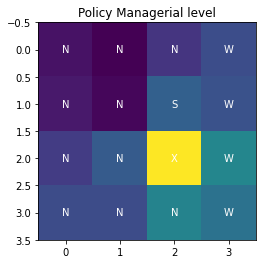

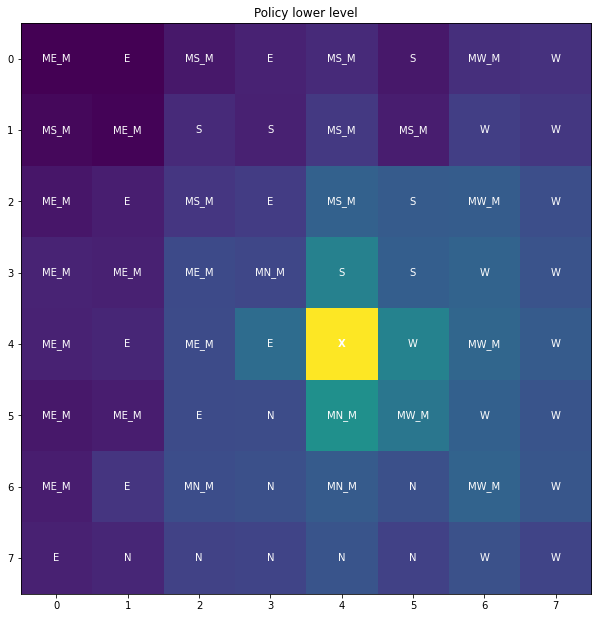

cccc
Init
Parameter containing:
tensor([[0.9725, 2.1355, 4.0047]], requires_grad=True) Parameter containing:
tensor([0.])
[0.9724619388580322, 2.1355209350585938, 4.004711151123047]
Ratio M/L: 1.8752853626383048
[['N' 'W' 'N' 'W']
 ['N' 'N' 'N' 'N']
 ['E' 'E' 'Search' 'W']
 ['N' 'W' 'N' 'W']]
[[list([(0, -28.85655975341797), (1, -31.190570831298828), (2, -30.525177001953125), (3, -30.937488555908203)])
  list([(0, -28.165264129638672), (1, -29.43088722229004), (2, -28.10700225830078), (3, -27.698867797851562)])
  list([(0, -24.31841278076172), (1, -25.952857971191406), (2, -27.451528549194336), (3, -24.723155975341797)])
  list([(0, -22.670053482055664), (1, -24.298187255859375), (2, -25.922088623046875), (3, -22.548574447631836)])]
 [list([(0, -25.810049057006836), (1, -28.44447135925293), (2, -28.920013427734375), (3, -30.46129608154297)])
  list([(0, -24.976627349853516), (1, -27.66288948059082), (2, -27.377174377441406), (3, -26.354549407958984)])
  list([(0, -16.459177017211914), 

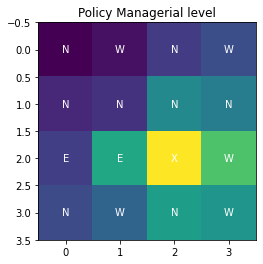

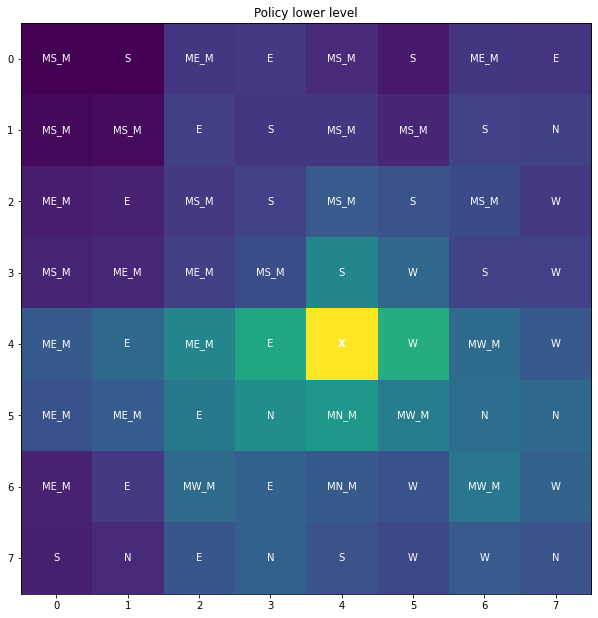

cccc
Nil
Parameter containing:
tensor([[1., 1., 1.]]) Parameter containing:
tensor([0.])
[1.0, 1.0, 1.0]
Ratio M/L: 1.0
[['S' 'S' 'S' 'S']
 ['S' 'N' 'S' 'N']
 ['N' 'E' 'Search' 'W']
 ['N' 'N' 'N' 'W']]
[[list([(0, -45.36400604248047), (1, -45.36361312866211), (2, -46.720375061035156), (3, -46.95014953613281)])
  list([(0, -49.06419372558594), (1, -48.67634582519531), (2, -50.37687683105469), (3, -49.83655548095703)])
  list([(0, -46.036773681640625), (1, -44.68055725097656), (2, -48.87178039550781), (3, -46.66120910644531)])
  list([(0, -49.87981414794922), (1, -49.85585403442383), (2, -53.459197998046875), (3, -49.85673141479492)])]
 [list([(0, -42.62975311279297), (1, -42.25313949584961), (2, -43.922752380371094), (3, -44.61343765258789)])
  list([(0, -44.251277923583984), (1, -44.260372161865234), (2, -46.136253356933594), (3, -45.278831481933594)])
  list([(0, -35.42948913574219), (1, -30.81765365600586), (2, -38.360801696777344), (3, -36.53962707519531)])
  list([(0, -41.637264251

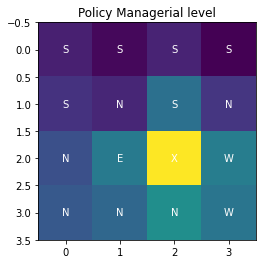

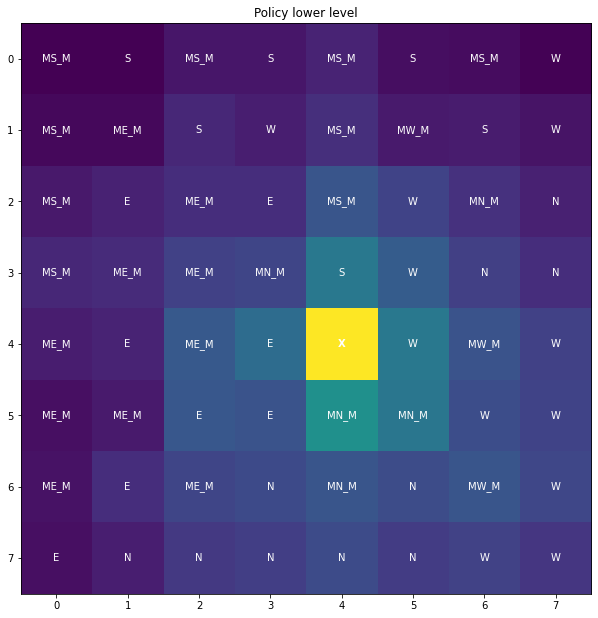

cccc
Exact
Parameter containing:
tensor([[1., 2., 4.]]) Parameter containing:
tensor([0.])
[1.0, 2.0, 4.0]
Ratio M/L: 2.0
[['E' 'E' 'S' 'W']
 ['S' 'E' 'S' 'N']
 ['E' 'E' 'Search' 'W']
 ['E' 'E' 'N' 'N']]
[[list([(0, -80.95279693603516), (1, -77.82613372802734), (2, -77.706787109375), (3, -83.83307647705078)])
  list([(0, -74.69730377197266), (1, -71.80848693847656), (2, -69.23247528076172), (3, -71.57807922363281)])
  list([(0, -65.05467987060547), (1, -61.32658386230469), (2, -65.20530700683594), (3, -64.2769546508789)])
  list([(0, -61.274620056152344), (1, -59.077674865722656), (2, -60.12007522583008), (3, -58.91648483276367)])]
 [list([(0, -72.18899536132812), (1, -69.75260925292969), (2, -70.25475311279297), (3, -76.33086395263672)])
  list([(0, -65.70716094970703), (1, -65.02168273925781), (2, -64.03541564941406), (3, -67.16918182373047)])
  list([(0, -43.61581802368164), (1, -38.239845275878906), (2, -46.869258880615234), (3, -45.176300048828125)])
  list([(0, -49.54045867919922

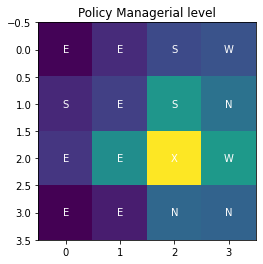

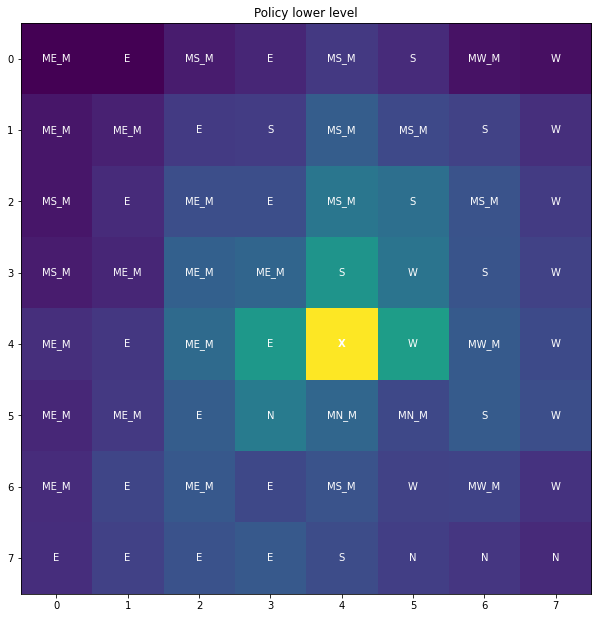

cccc
Learn 5.19
Init 5.65
Nil 7.01
Exact 9.59


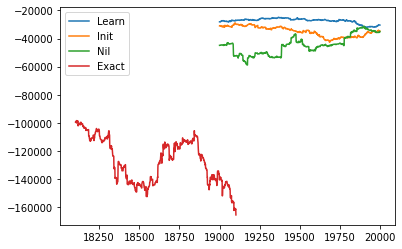

Learn 5.19
Init 5.65
Nil 7.01
Exact 9.59


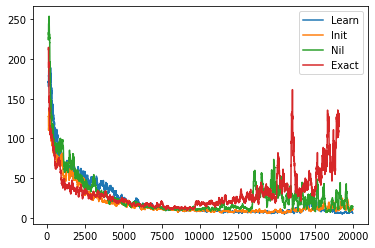

Learn -75.45
Init -68.88
Nil -86.13
Exact -137.79


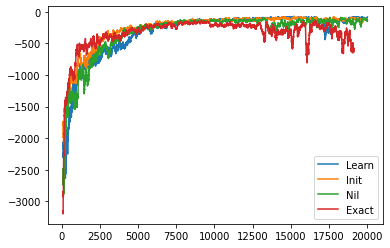

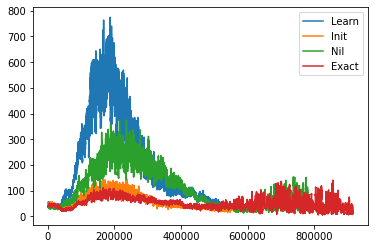

In [20]:
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    nn=r_dict_5[x]['Q_policy']
    out=[]
    
    for i in range(3):
        x=torch.zeros(3)
        x[i]=1
    #     ([0.,0.,1.]
        out.append(nn.man_layer(x).item())
    
    
    print(labelp)
    print("=====================")
    print(nn.man_layer.weight,nn.man_layer.bias)
    print(out)
    print('Ratio M/L:',out[2]/out[1])
    print("=====================")
    print_policy(nn, env3, 0, 0)
    print("=====================")

    
#     pd.Series(r_dict_3[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
# plt.legend()
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    
    print(labelp,pd.Series(r_dict_5[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_5[x]['rewards']).rolling(300).sum().tail(1000).plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    
    print(labelp,pd.Series(r_dict_5[x]['episode_durations']).rolling(100).mean().min())

    pd.Series(r_dict_5[x]['episode_durations']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    print(labelp,pd.Series(r_dict_5[x]['rewards']).rolling(100).mean().max())

    pd.Series(r_dict_5[x]['rewards']).rolling(100).mean().plot(label=labelp)
plt.legend()
plt.show()
for x in range(4):
    labelp=r_dict_5[x]['man_init']
    pd.Series(r_dict_5[x]['losses']).rolling(1000).mean().plot(label=labelp)
plt.legend()
plt.show()

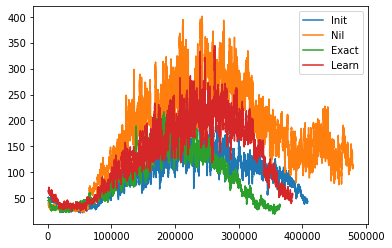

Init 22.200158096338033
Nil 22.88762447284077
Exact 19.986174420386465
Learn 25.51496598204514


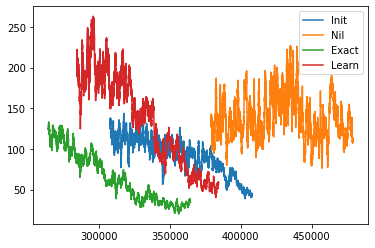

In [122]:
for x in range(4):
    labelp=r_dict_3[x]['man_init']
    pd.Series(r_dict_3[x]['losses']).rolling(1000).mean().tail(100000).plot(label=labelp)
    print(labelp,pd.Series(r_dict_3[x]['losses']).rolling(1000).mean().min())
plt.legend()

In [64]:
np.array([pd.Series(r_dict_3[x]['losses']) for x in range(4)])

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([0           0.944539
1           4.000000
2         116.894913
3           0.962077
4           0.956444
             ...    
395262      1.541258
395263      4.000000
395264      8.323048
395265     36.082764
395266      7.426988
Length: 395267, dtype: float64,
       0           0.868928
1           0.853750
2           8.439255
3         121.108536
4           0.979999
             ...    
354883      1.000000
354884      0.233869
354885      5.187146
354886     46.029171
354887      6.011152
Length: 354888, dtype: float64,
       0           1.006482
1           1.007505
2           9.000000
3         117.600548
4           0.837997
             ...    
377156     13.437597
377157      3.808572
377158    231.068237
377159     29.945692
377160     15.245069
Length: 377161, dtype: float64,
       0           0.972997
1           4.000000
2         121.008476
3           0.829128
4           3.806385
             ...    
392085    179.027435
392086      1.000000
392087      8.5

In [23]:
pd.Series(losses).rolling(999).mean().tail(1).values[0]

96.32986692258063

In [24]:
import collections

In [25]:
a=collections.Counter([tuple(x) for x in ss])

<AxesSubplot:>

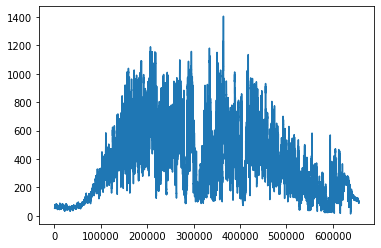

In [26]:
pd.Series(losses).rolling(500).mean().plot()

In [27]:
Q_policy

QNetwork(
  (l1): Linear(in_features=98, out_features=98, bias=True)
  (l2): Linear(in_features=98, out_features=98, bias=True)
  (task_layer): Linear(in_features=5, out_features=98, bias=True)
  (man_layer): Linear(in_features=3, out_features=1, bias=True)
  (l3): Linear(in_features=98, out_features=5, bias=True)
  (conv_1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (subsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [28]:
Q_policy.man_layer.bias

#

Parameter containing:
tensor([-0.4130], requires_grad=True)

In [29]:
Q_policy.man_layer.weight


Parameter containing:
tensor([[ 0.0246, -0.4764, -0.5448]], requires_grad=True)

In [30]:
for i in range(3):
    x=torch.zeros(3)
    x[i]=1
#     ([0.,0.,1.]
    print(Q_policy.man_layer(x))


tensor([-0.3883], grad_fn=<AddBackward0>)
tensor([-0.8894], grad_fn=<AddBackward0>)
tensor([-0.9577], grad_fn=<AddBackward0>)


In [31]:
pd.Series(episode_durations).rolling(100).mean().idxmin()

8885

In [32]:
Q_policy

QNetwork(
  (l1): Linear(in_features=98, out_features=98, bias=True)
  (l2): Linear(in_features=98, out_features=98, bias=True)
  (task_layer): Linear(in_features=5, out_features=98, bias=True)
  (man_layer): Linear(in_features=3, out_features=1, bias=True)
  (l3): Linear(in_features=98, out_features=5, bias=True)
  (conv_1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (subsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [33]:
PATH = "C:/Users/howar/AppData/Local/Programs/netron"
torch.save(Q_policy.state_dict(), os.path.join(PATH,"filename.pth"))

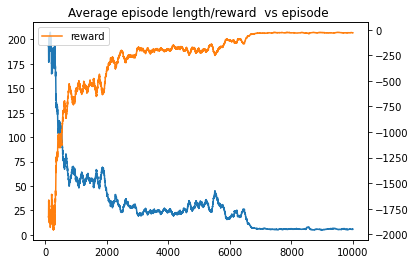

In [15]:

pd.Series(episode_durations).rolling(100).mean().plot(label='episode duration')
pd.Series(rewards).rolling(100).mean().plot(secondary_y=True,label='reward')
plt.title('Average episode length/reward  vs episode ')
plt.legend()

In [16]:
pd.Series(episode_durations).rolling(100).mean().idxmin()

8739

In [17]:
pd.Series(episode_durations).rolling(100).mean().min()

4.97

In [18]:
pd.Series(rewards).rolling(100).mean().max()

-23.61

In [19]:
pd.Series(rewards).rolling(100).mean().idxmax()

9525

In [20]:
a=pd.Series(rewards).rolling(100).mean()-pd.Series(rewards).rolling(100).mean().shift(-100)

In [89]:
a.tail(3000).idxmin()

7326

<AxesSubplot:>

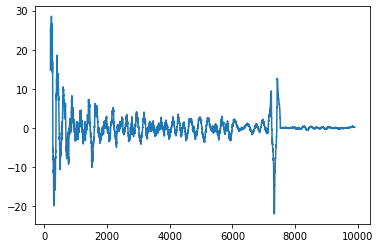

In [90]:
a.diff().rolling(100).mean().plot()

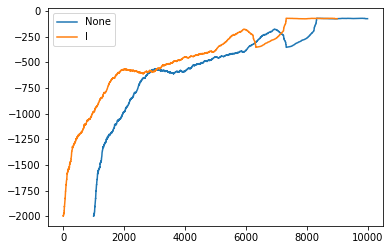

In [91]:
pd.Series(rewards).rolling(1000).mean().plot()
pd.Series(rewards).rolling(1000).mean().shift(-1000).plot(label='l')
plt.legend()

In [92]:
pd.Series(rewards).rolling(100).mean().max()

-53.25

In [93]:
pd.Series(rewards).rolling(50).mean()

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
9995   -73.68
9996   -73.98
9997   -73.98
9998   -74.94
9999   -75.36
Length: 10000, dtype: float64

In [127]:
Q_policy.man_layer.weight

Parameter containing:
tensor([[ 0.0246, -0.5033, -0.5646]], requires_grad=True)